# Delays prediction - machine learning models (regression)

Katarzyna Mocio 429956 
Marcin Miszkiel 432418

# 1. Prepare necessary libraries

In [51]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option("display.max_columns",100)

# Data wrangling
import numpy as np
from datetime import datetime as dt 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Modelling with scikit-learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import optuna
import sklearn



Delays for regression
Your task is to apply various ML algorithms (see the rules below) to build a model explaining the delays of the flights based on the training sample and generate predictions for all observations from the test sample.

The dataset includes 1631327 observations in the training sample and 407832 in the test sample and the following columns:

Weekday – Day of the week when the flight occurred (1 for Sunday, 7 for Saturday).
Month_of_Year – The numerical month (1-12) when the flight took place.
Day_of_Month – The day of the month (1-31) when the flight occurred.
Scheduled_Departure_Time – The scheduled local time of flight departure.
Scheduled_Arrival_Time – The scheduled local time of flight arrival.
Marketing_Airline – The airline code under which the flight was marketed.
Marketing_Airline_DOT_ID – Department of Transportation identifier for the marketing airline.
Flight_Number – The number assigned to the flight by the operating airline.
Origin_Airport_ID – Unique identifier for the departure airport.
Destination_Airport_ID – Unique identifier for the arrival airport.
Flight_Cancelled – Indicator of whether the flight was cancelled (1 = Yes, 0 = No).
Departure_State – The state code of the departure location.
Arrival_State – The state code of the arrival location.
Departure_Delay – Total delay in minutes at departure.
Diverted_Airport_Landings – Count of unplanned landings at other airports.
Taxi_Out_Time – Time in minutes from gate departure until takeoff.
Taxi_In_Time – Time in minutes from landing to gate arrival.
Flight_Diverted – Indicator of whether the flight was diverted (1 = Yes, 0 = No).
Actual_Departure_Time – The actual local time the flight departed.
Flight_Duration – The duration of the flight in minutes from takeoff to landing.
Flight_Distance – The total distance covered by the flight in miles.
Origin_Temperature – The temperature at the origin airport at the time of the flight’s departure.
Destination_Temperature – The temperature at the destination airport at the time of the flight’s arrival.
Origin_Wind_Speed – The wind speed at the origin airport during the departure of the flight.
Destination_Wind_Speed – The wind speed at the destination airport during the departure of the flight.
Origin_Precipitation – The amount of precipitation, such as rain or snow, at the origin airport around the flight’s departure time.
Destination_Precipitation – The amount of precipitation, such as rain or snow, at the destination airport around the flight’s arrival time.
Arrival_Delay – Total delay in minutes at arrival (outcome variable, only in the training sample)

Let's load the data and look at the first five observations

In [52]:
delays = pd.read_csv('delays_train.csv')

delays.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
0,6,6,25,1222,1444,B6,20409,520,10397,12478.00,False,GA,NY,NaN,NaN,0,16.00,10.00,False,1224.00,107.00,760.00,25.14,19.36,21.02,15.45,0.00,0.00
1,2,6,21,1216,1304,NaN,19805,6297,14107,15376.00,False,AZ,AZ,0.09,-4.18,0,16.00,5.00,False,1216.00,23.00,110.00,13.28,20.47,18.05,12.91,0.00,0.00
2,3,1,5,1945,2055,DL,19790,4124,13487,13076.00,False,MN,WI,NaN,5.04,0,34.00,5.00,False,1945.00,36.00,119.00,17.82,13.97,21.61,17.98,0.00,0.10
3,2,3,22,700,924,AA,19805,1538,15624,11298.00,False,FL,TX,-1.80,-0.21,0,10.00,11.00,False,658.00,125.00,641.00,24.56,14.51,24.95,22.63,0.00,0.00
4,4,7,14,2130,2359,NaN,19930,1116,14747,12889.00,False,WA,NV,NaN,14.01,0,23.00,7.00,False,2133.00,130.00,867.00,8.82,10.87,17.43,17.40,0.00,0.00


In [53]:
delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1467776 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1468233 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [54]:
pd.set_option('display.float_format', '{:.2f}'.format)
delays.describe()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
count,1631327.00,1631327.00,1631327.00,1631327.00,1631327.00,1631327.00,1631327.00,1631327.00,1468233.00,1424866.00,1420021.00,1631327.00,1582102.00,1581460.00,1583001.00,1419837.00,1468137.00,1468137.00,1468137.00,1419837.00,1419837.00,1631327.00,1631327.00
mean,4.01,4.08,15.72,1329.79,1486.05,19830.81,2561.29,12660.01,12658.28,13.11,7.50,0.00,16.96,7.90,1334.42,111.08,798.00,16.59,16.60,20.08,20.08,0.10,0.11
std,2.01,2.00,8.76,490.39,518.65,276.15,1745.16,1522.94,1521.78,53.96,55.62,0.12,9.47,6.66,505.49,70.03,591.41,5.14,5.13,4.30,4.30,0.34,0.34
min,1.00,1.00,1.00,1.00,1.00,19393.00,1.00,10135.00,10135.00,-78.33,-100.04,0.00,1.00,1.00,1.00,8.00,31.00,-7.81,-8.31,1.72,1.99,0.00,0.00
25%,2.00,2.00,8.00,915.00,1103.00,19790.00,1106.00,11292.00,11292.00,-5.08,-14.42,0.00,11.00,4.00,917.00,60.00,368.00,13.12,13.13,17.09,17.09,0.00,0.00
50%,4.00,4.00,16.00,1320.00,1512.00,19805.00,2228.00,12889.00,12889.00,-1.57,-5.11,0.00,15.00,6.00,1325.00,93.00,643.00,16.58,16.59,19.87,19.88,0.00,0.00
75%,6.00,6.00,23.00,1735.00,1920.00,19977.00,3874.00,14027.00,14027.00,10.71,10.18,0.00,19.00,9.00,1744.00,141.00,1035.00,20.04,20.05,22.85,22.85,0.00,0.00
max,7.00,7.00,31.00,2359.00,2359.00,20436.00,9680.00,16869.00,16869.00,7223.21,7232.23,9.00,221.00,287.00,2400.00,675.00,5095.00,40.00,40.00,42.58,42.77,2.00,2.00


# Handling with missing values

In [55]:
an = pd.read_csv('airline_name.csv', index_col=False)
an = an.set_index('id')['name'].to_dict()
delays['Marketing_Airline'] = delays['Marketing_Airline_DOT_ID'].map(an)

In [56]:
grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time'])
value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
airportD = value_counts_dest_id.reset_index()
airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Count']

delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
map_dict = airportD.set_index('key')['Destination_Airport_ID'].to_dict()
delays['Destination_Airport_ID'] = delays['Destination_Airport_ID'].fillna(delays['key'].map(map_dict))

In [57]:
cols = ['Taxi_In_Time', 'Taxi_Out_Time', 'Flight_Duration', 'Flight_Distance']

for col in cols:
    grouped = delays.groupby(['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', col])
    value_counts_dest_id = grouped['Marketing_Airline'].value_counts()
    airportD = value_counts_dest_id.reset_index()
    airportD.columns = ['Marketing_Airline', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID', 'Weekday', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', col, 'Count']

    delays['key'] = delays['Marketing_Airline'] + '_' + delays['Flight_Number'].astype(str) + '_' + delays['Origin_Airport_ID'].astype(str) + '_' + delays['Destination_Airport_ID'].astype(str) + '_' + delays['Weekday'].astype(str) + '_' + delays['Scheduled_Departure_Time'].astype(str) + '_' + delays['Scheduled_Arrival_Time'].astype(str)
    airportD['key'] = airportD['Marketing_Airline'] + '_' + airportD['Flight_Number'].astype(str) + '_' + airportD['Origin_Airport_ID'].astype(str) + '_' + airportD['Destination_Airport_ID'].astype(str) + '_' + airportD['Weekday'].astype(str) + '_' + airportD['Scheduled_Departure_Time'].astype(str) + '_' + airportD['Scheduled_Arrival_Time'].astype(str)
                                                                                                                                                                                                                                                                                                   
    map_dict = airportD.set_index('key')[col].to_dict()
    delays[col] = delays[col].fillna(delays['key'].map(map_dict))

In [58]:
cols = ['Origin_Temperature', 'Destination_Temperature', 'Origin_Wind_Speed', 'Destination_Wind_Speed']

for col in cols:
    mode = delays[col].mode()[0]
    delays[col] = delays[col].fillna(mode)

# Filter Train data to only not canelled flights -> in test data if flight is cancelled return NaN as prediction

In [59]:
delays = delays[delays['Flight_Cancelled'] == False]
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581877 entries, 0 to 1631326
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1581877 non-null  int64  
 1   Month_of_Year              1581877 non-null  int64  
 2   Day_of_Month               1581877 non-null  int64  
 3   Scheduled_Departure_Time   1581877 non-null  int64  
 4   Scheduled_Arrival_Time     1581877 non-null  int64  
 5   Marketing_Airline          1581877 non-null  object 
 6   Marketing_Airline_DOT_ID   1581877 non-null  int64  
 7   Flight_Number              1581877 non-null  int64  
 8   Origin_Airport_ID          1581877 non-null  int64  
 9   Destination_Airport_ID     1544540 non-null  float64
 10  Flight_Cancelled           1581877 non-null  bool   
 11  Departure_State            1581877 non-null  object 
 12  Arrival_State              1581877 non-null  object 
 13  Departure_Delay  

# Missing values in departure delay

In [60]:
def hhmm_to_minutes(hhmm):
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

delays['Scheduled_Minutes'] = delays['Scheduled_Departure_Time'].apply(hhmm_to_minutes)
delays['Actual_Minutes'] = delays['Actual_Departure_Time'].apply(hhmm_to_minutes)

delays['Departure_Delay'] = delays['Departure_Delay'].fillna(delays['Actual_Minutes'] - delays['Scheduled_Minutes'])

delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] + 1440 if row['Departure_Delay'] < -90 else row['Departure_Delay'], axis=1
)


In [61]:
delays['test'] = round(delays['Departure_Delay'],0) - (delays['Actual_Minutes'] - delays['Scheduled_Minutes'])
check = delays['test'].value_counts()
check

test
0.00        1546864
1.00          13028
-1.00         12982
1440.00        8816
1439.00          75
1441.00          49
-1440.00         47
1380.00           7
2880.00           6
7200.00           1
-60.00            1
60.00             1
Name: count, dtype: int64

dep delay is a difference between real dep time and schedulded dep time. test value = 0 means that everything is correct, 1440, 2880 and higher multipliers of 1440 are also good (negative and positive). It means that we have 1,2 days delay unobserved in difference between hours. Values lower or higher than 1 than values mentioned above are also good - it's rounding dep_delay error. Values 1380, -60, 60 have missing 1 hour. If it will be for real 23h delay we will see this time in a difference between real dep time and schedulded dep time. We have to add or substract 60min to Departure_Delay.

In [62]:
delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] + 60 if (row['test'] == -60) | (row['test'] == 1380) else row['Departure_Delay'], axis=1
)

delays['Departure_Delay'] = delays.apply(
    lambda row: row['Departure_Delay'] - 60 if row['test'] == 60 else row['Departure_Delay'], axis=1
)

delays['test'] = round(delays['Departure_Delay'],0) - (delays['Actual_Minutes'] - delays['Scheduled_Minutes'])
check = delays['test'].value_counts()
check

test
0.00        1546866
1.00          13028
-1.00         12982
1440.00        8823
1439.00          75
1441.00          49
-1440.00         47
2880.00           6
7200.00           1
Name: count, dtype: int64

In [63]:
delays = delays.drop(['key', 'Actual_Minutes', 'Scheduled_Minutes', 'test'], axis=1)

# Deleting observations where Arrival_Delay is NaN. It's better to remove observations from train data which have missing values in target variable.

In [64]:
delays = delays[delays['Arrival_Delay'].notnull()]
delays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1420021 entries, 1 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1420021 non-null  int64  
 1   Month_of_Year              1420021 non-null  int64  
 2   Day_of_Month               1420021 non-null  int64  
 3   Scheduled_Departure_Time   1420021 non-null  int64  
 4   Scheduled_Arrival_Time     1420021 non-null  int64  
 5   Marketing_Airline          1420021 non-null  object 
 6   Marketing_Airline_DOT_ID   1420021 non-null  int64  
 7   Flight_Number              1420021 non-null  int64  
 8   Origin_Airport_ID          1420021 non-null  int64  
 9   Destination_Airport_ID     1386412 non-null  float64
 10  Flight_Cancelled           1420021 non-null  bool   
 11  Departure_State            1420021 non-null  object 
 12  Arrival_State              1420021 non-null  object 
 13  Departure_Delay  

# Data Transformation

In [65]:
weekdays = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

delays['Weekday'] = delays['Weekday'].map(weekdays)
delays['Month_of_Year'] = delays['Month_of_Year'].map(months)

columns_to_convert = ['Marketing_Airline_DOT_ID', 'Flight_Number', 'Origin_Airport_ID', 'Destination_Airport_ID']
for column in columns_to_convert:
    delays[column] = delays[column].astype('object')

delays['Scheduled_Departure_Time'] = delays['Scheduled_Departure_Time'].astype('int64')
delays['Actual_Departure_Time'] = delays['Actual_Departure_Time'].astype('int64')

delays.dtypes

Weekday                       object
Month_of_Year                 object
Day_of_Month                   int64
Scheduled_Departure_Time       int64
Scheduled_Arrival_Time         int64
Marketing_Airline             object
Marketing_Airline_DOT_ID      object
Flight_Number                 object
Origin_Airport_ID             object
Destination_Airport_ID        object
Flight_Cancelled                bool
Departure_State               object
Arrival_State                 object
Departure_Delay              float64
Arrival_Delay                float64
Diverted_Airport_Landings      int64
Taxi_Out_Time                float64
Taxi_In_Time                 float64
Flight_Diverted                 bool
Actual_Departure_Time          int64
Flight_Duration              float64
Flight_Distance              float64
Origin_Temperature           float64
Destination_Temperature      float64
Origin_Wind_Speed            float64
Destination_Wind_Speed       float64
Origin_Precipitation         float64
D

In [66]:
def assign_time_slot(time):
    hour = int(time / 100)
    minute = time % 100
    total_hour = hour + minute / 60.0
    
    if 0 <= total_hour < 6:
        return '0-6'
    elif 6 <= total_hour < 12:
        return '6-12'
    elif 12 <= total_hour < 18:
        return '12-18'
    else:
        return '18-24'
    
delays['Scheduled_Departure_Time'] = delays['Scheduled_Departure_Time'].apply(assign_time_slot)
delays['Scheduled_Arrival_Time'] = delays['Scheduled_Arrival_Time'].apply(assign_time_slot)
delays['Actual_Departure_Time'] = delays['Actual_Departure_Time'].apply(assign_time_slot)

delays

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,Departure_State,Arrival_State,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
1,Tuesday,June,21,12-18,12-18,AA,19805,6297,14107,15376.00,False,AZ,AZ,0.09,-4.18,0,16.00,5.00,False,12-18,23.00,110.00,13.28,20.47,18.05,12.91,0.00,0.00
2,Wednesday,January,5,18-24,18-24,DL,19790,4124,13487,13076.00,False,MN,WI,0.00,5.04,0,34.00,5.00,False,18-24,36.00,119.00,17.82,13.97,21.61,17.98,0.00,0.10
3,Tuesday,March,22,6-12,6-12,AA,19805,1538,15624,11298.00,False,FL,TX,-1.80,-0.21,0,10.00,11.00,False,6-12,125.00,641.00,24.56,14.51,24.95,22.63,0.00,0.00
4,Thursday,July,14,18-24,18-24,AS,19930,1116,14747,12889.00,False,WA,NV,3.00,14.01,0,23.00,7.00,False,18-24,130.00,867.00,8.82,10.87,17.43,17.40,0.00,0.00
5,Monday,May,30,6-12,6-12,WN,19393,1336,14831,14679.00,False,CA,CA,-2.18,-14.07,0,10.00,5.00,False,6-12,58.00,417.00,9.36,15.98,19.00,16.88,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631321,Saturday,June,4,12-18,18-24,NK,20416,1308,11697,10821.00,False,FL,MD,25.02,8.01,0,15.00,5.00,False,12-18,119.00,925.00,19.31,18.69,19.29,20.95,0.00,0.10
1631323,Tuesday,April,19,18-24,6-12,AA,19805,276,14771,12478.00,False,CA,NY,-8.04,-10.02,0,24.00,30.00,False,18-24,285.00,2586.00,33.96,15.47,25.78,24.90,0.10,0.00
1631324,Friday,June,10,6-12,6-12,UA,19977,5279,11721,13930.00,False,MI,IL,-1.05,11.91,0,40.00,9.00,False,6-12,41.00,223.00,12.92,25.35,11.85,14.32,0.00,0.00
1631325,Wednesday,March,30,12-18,12-18,AS,19930,421,14747,14057.00,False,WA,OR,-5.10,-1.99,0,18.00,11.00,False,12-18,29.00,129.00,13.73,13.93,16.62,18.73,0.00,0.10


In [67]:
pd.set_option('display.float_format', '{:.2f}'.format)
delays.describe()

,Day_of_Month,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
count,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1384837.00,1386207.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00
mean,15.78,12.99,7.50,0.00,16.95,7.89,111.19,798.66,18.94,18.94,18.24,18.27,0.10,0.11
std,8.73,53.31,55.62,0.00,9.47,6.65,70.07,593.12,8.55,8.55,6.86,6.79,0.34,0.34
min,1.00,-78.33,-100.04,0.00,1.00,1.00,8.00,31.00,-7.81,-6.43,1.72,1.99,0.00,0.00
25%,8.00,-5.06,-14.42,0.00,11.00,4.00,60.00,366.00,13.56,13.57,15.93,15.94,0.00,0.00
50%,16.00,-1.61,-5.11,0.00,15.00,6.00,94.00,642.00,17.30,17.30,19.28,19.28,0.00,0.00
75%,23.00,10.54,10.18,0.00,19.00,9.00,141.00,1035.00,21.57,21.57,22.46,22.47,0.00,0.00
max,31.00,7223.21,7232.23,0.00,221.00,280.00,675.00,5095.00,40.00,40.00,42.58,42.77,2.00,2.00


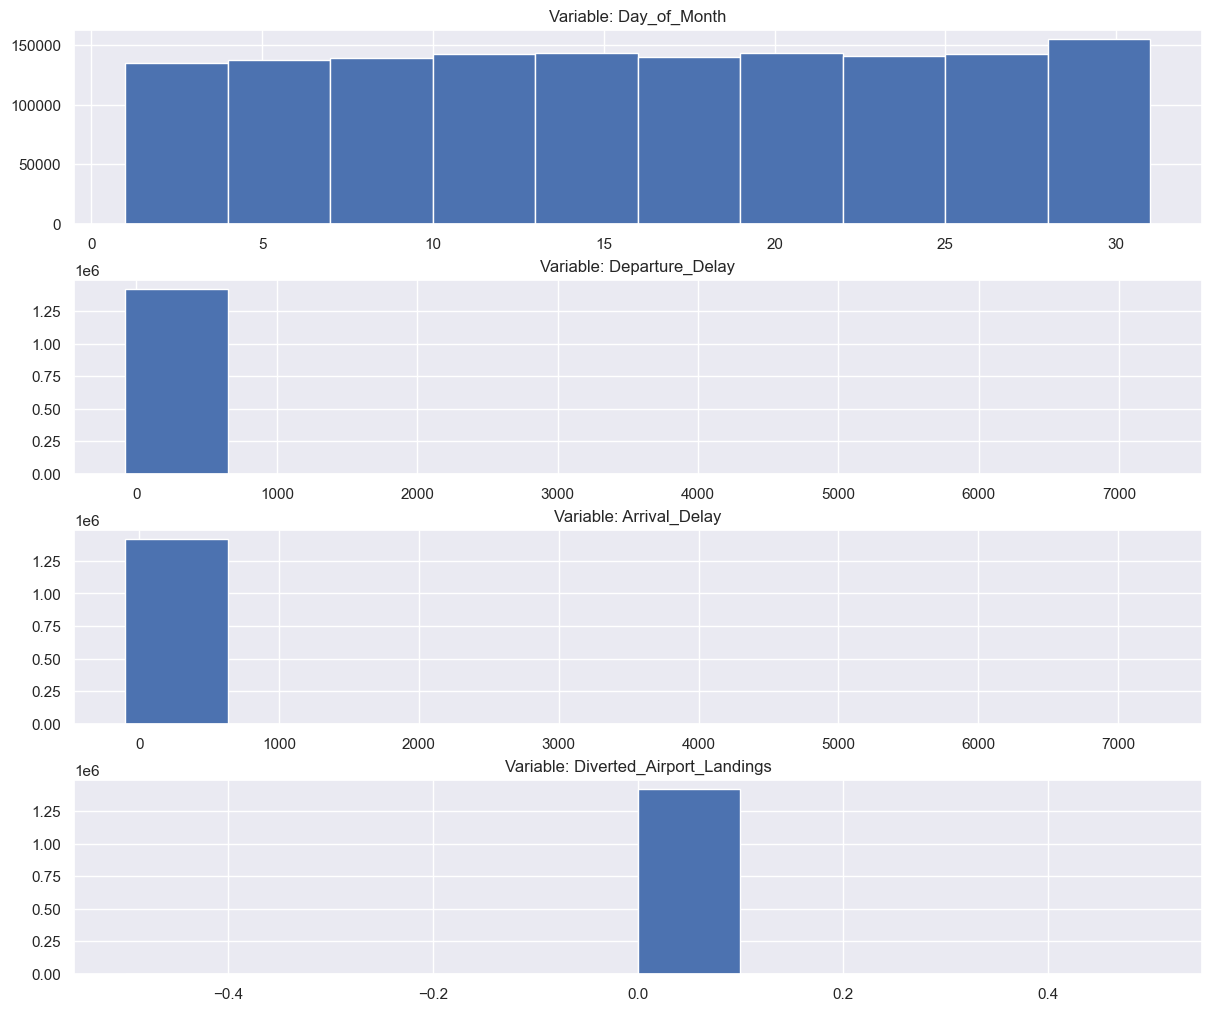

In [68]:
numericalVar = ['Day_of_Month', 'Departure_Delay', 'Arrival_Delay', 'Diverted_Airport_Landings']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

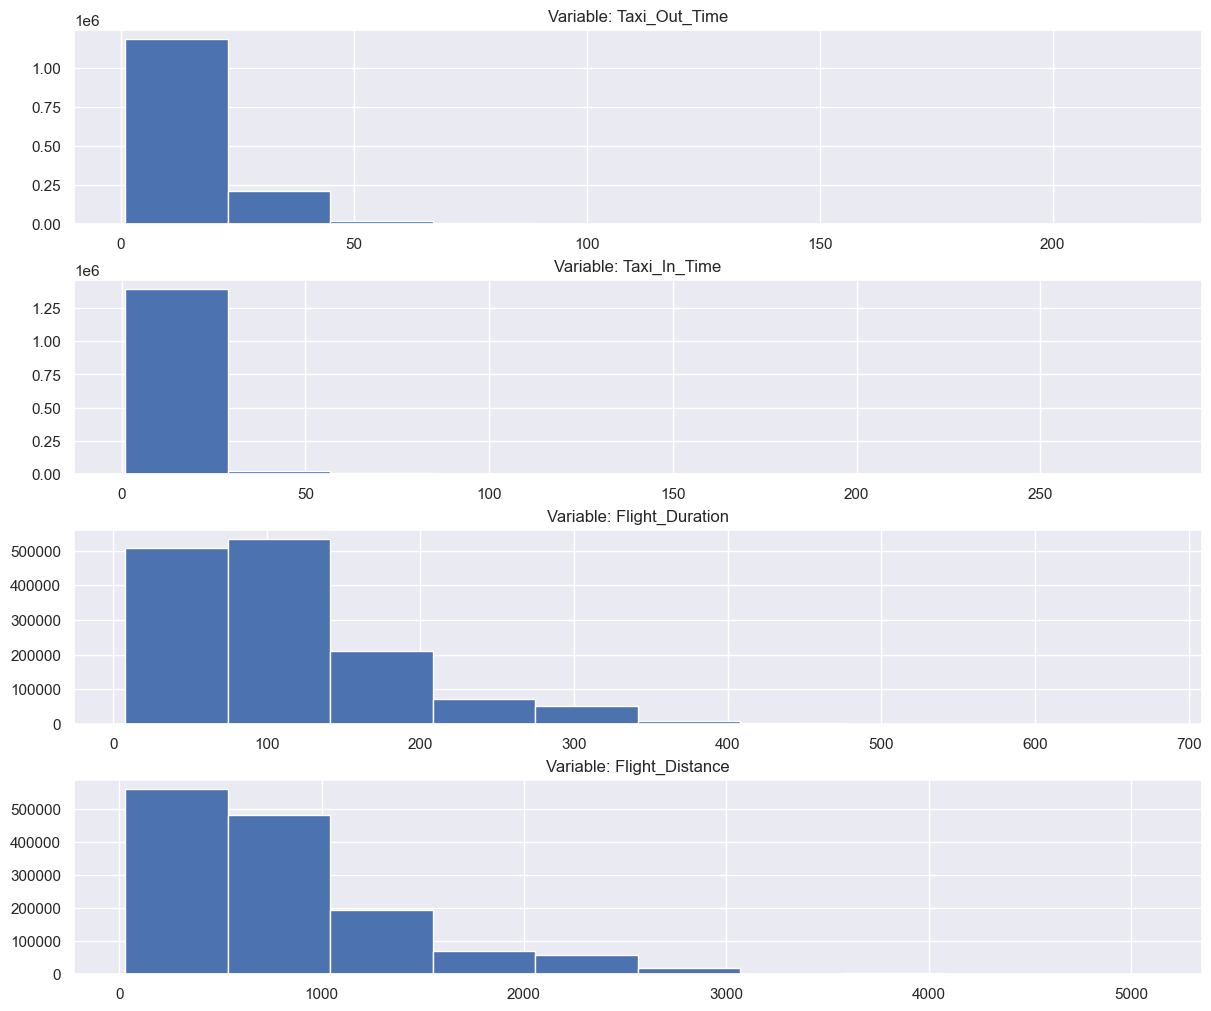

In [69]:
numericalVar = ['Taxi_Out_Time', 'Taxi_In_Time', 'Flight_Duration', 'Flight_Distance']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

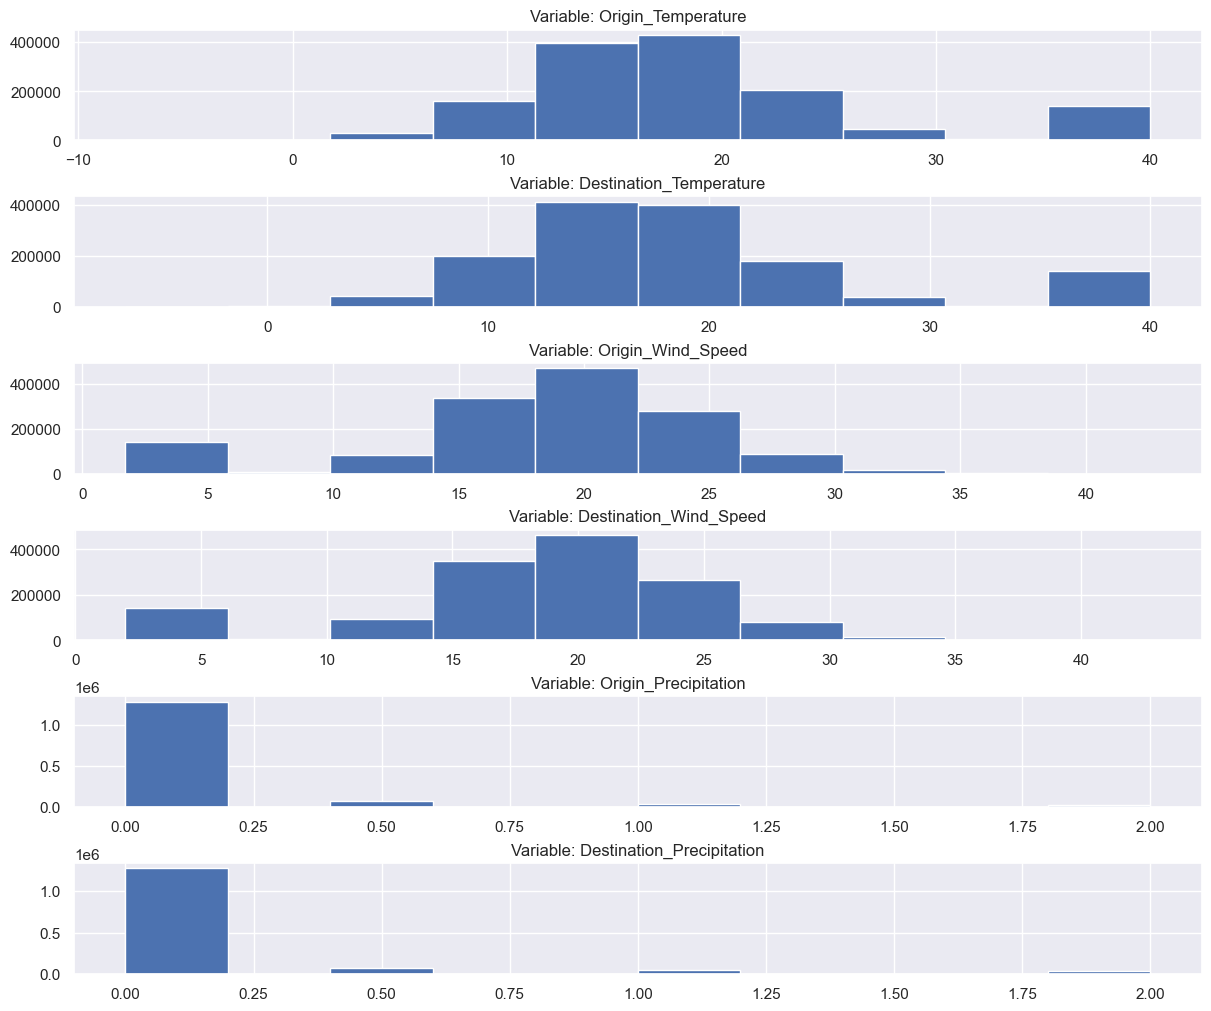

In [70]:
numericalVar = ['Origin_Temperature', 'Destination_Temperature', 'Origin_Wind_Speed', 'Destination_Wind_Speed', 'Origin_Precipitation', 'Destination_Precipitation']
fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

In [71]:
delays['Departure_Delay'] = delays['Departure_Delay'] + 150
delays['Departure_Delay'] = np.log1p(delays['Departure_Delay'])
delays['Arrival_Delay'] = delays['Arrival_Delay'] + 150
delays['Arrival_Delay'] = np.log1p(delays['Arrival_Delay'])
delays['Taxi_Out_Time'] = np.log1p(delays['Taxi_Out_Time'])
delays['Taxi_In_Time'] = np.log1p(delays['Taxi_In_Time'])
delays['Flight_Duration'] = np.log1p(delays['Flight_Duration'])
delays['Flight_Distance'] = np.log1p(delays['Flight_Distance'])

scaler = StandardScaler()
delays['Origin_Temperature'] = scaler.fit_transform(delays[['Origin_Temperature']])
delays['Origin_Wind_Speed'] = scaler.fit_transform(delays[['Origin_Wind_Speed']])
delays['Destination_Temperature'] = scaler.fit_transform(delays[['Destination_Temperature']])
delays['Destination_Wind_Speed'] = scaler.fit_transform(delays[['Destination_Wind_Speed']])

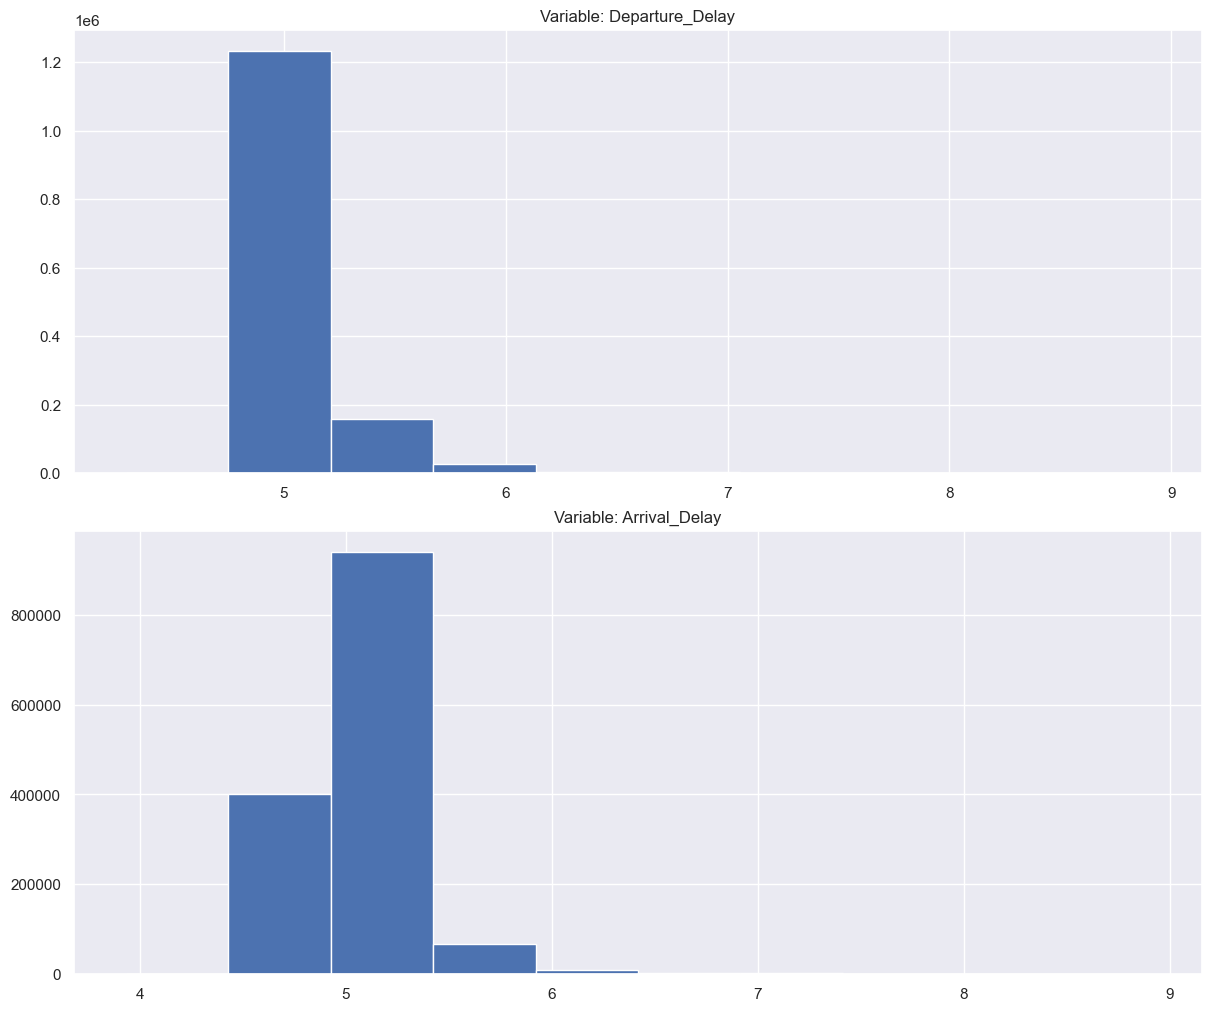

In [72]:
numericalVar = ['Departure_Delay', 'Arrival_Delay']
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

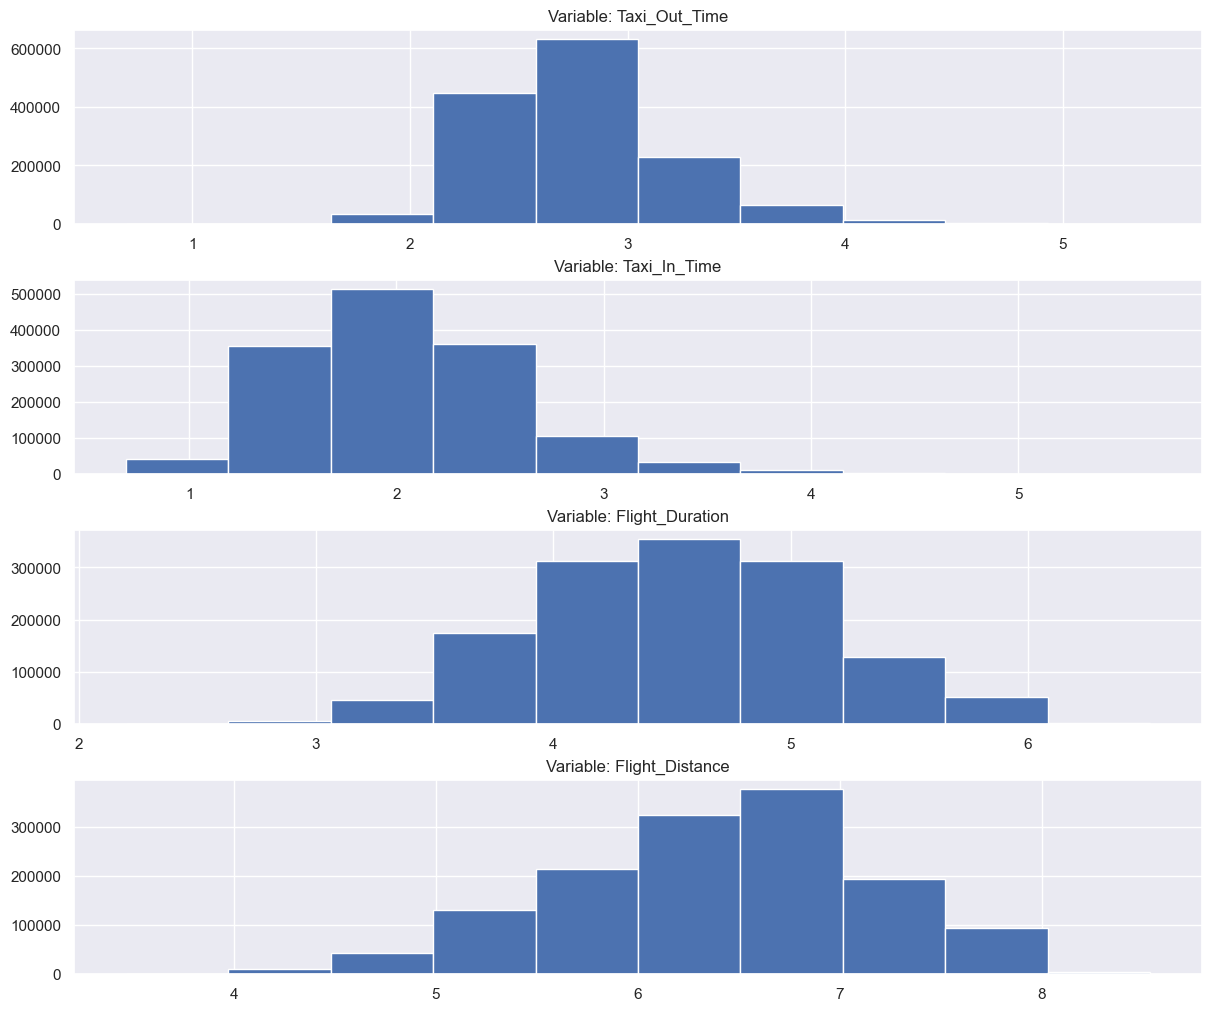

In [73]:
numericalVar = ['Taxi_Out_Time', 'Taxi_In_Time', 'Flight_Duration', 'Flight_Distance']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')
    

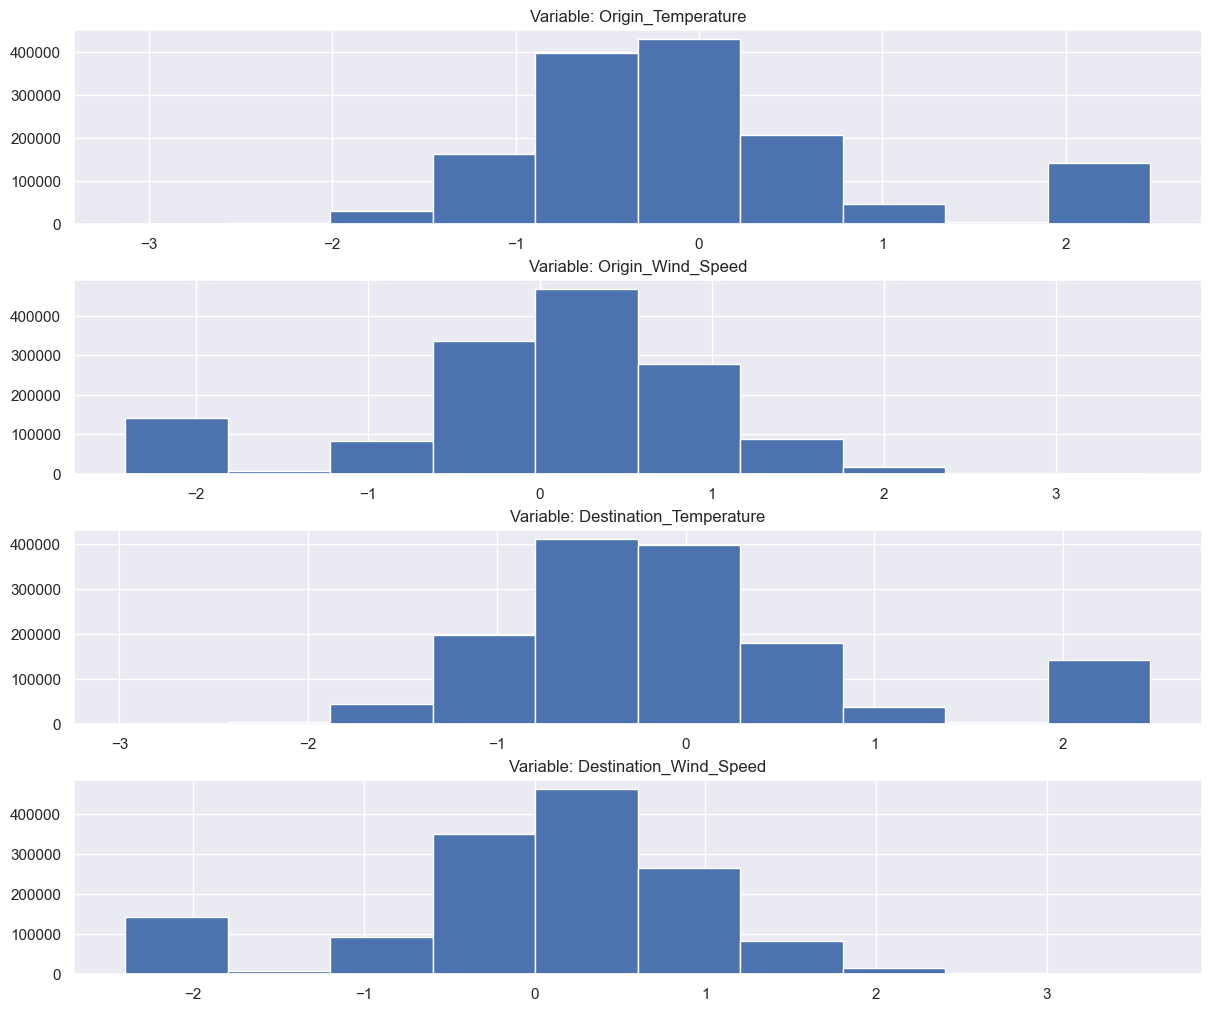

In [74]:
numericalVar = ['Origin_Temperature', 'Origin_Wind_Speed', 'Destination_Temperature', 'Destination_Wind_Speed']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 10),
                        constrained_layout=True)
for idx, col in enumerate(numericalVar):
    axs[idx].hist(delays[f'{col}'])
    axs[idx].set_title(f'Variable: {col}')

# Correlation Matrix

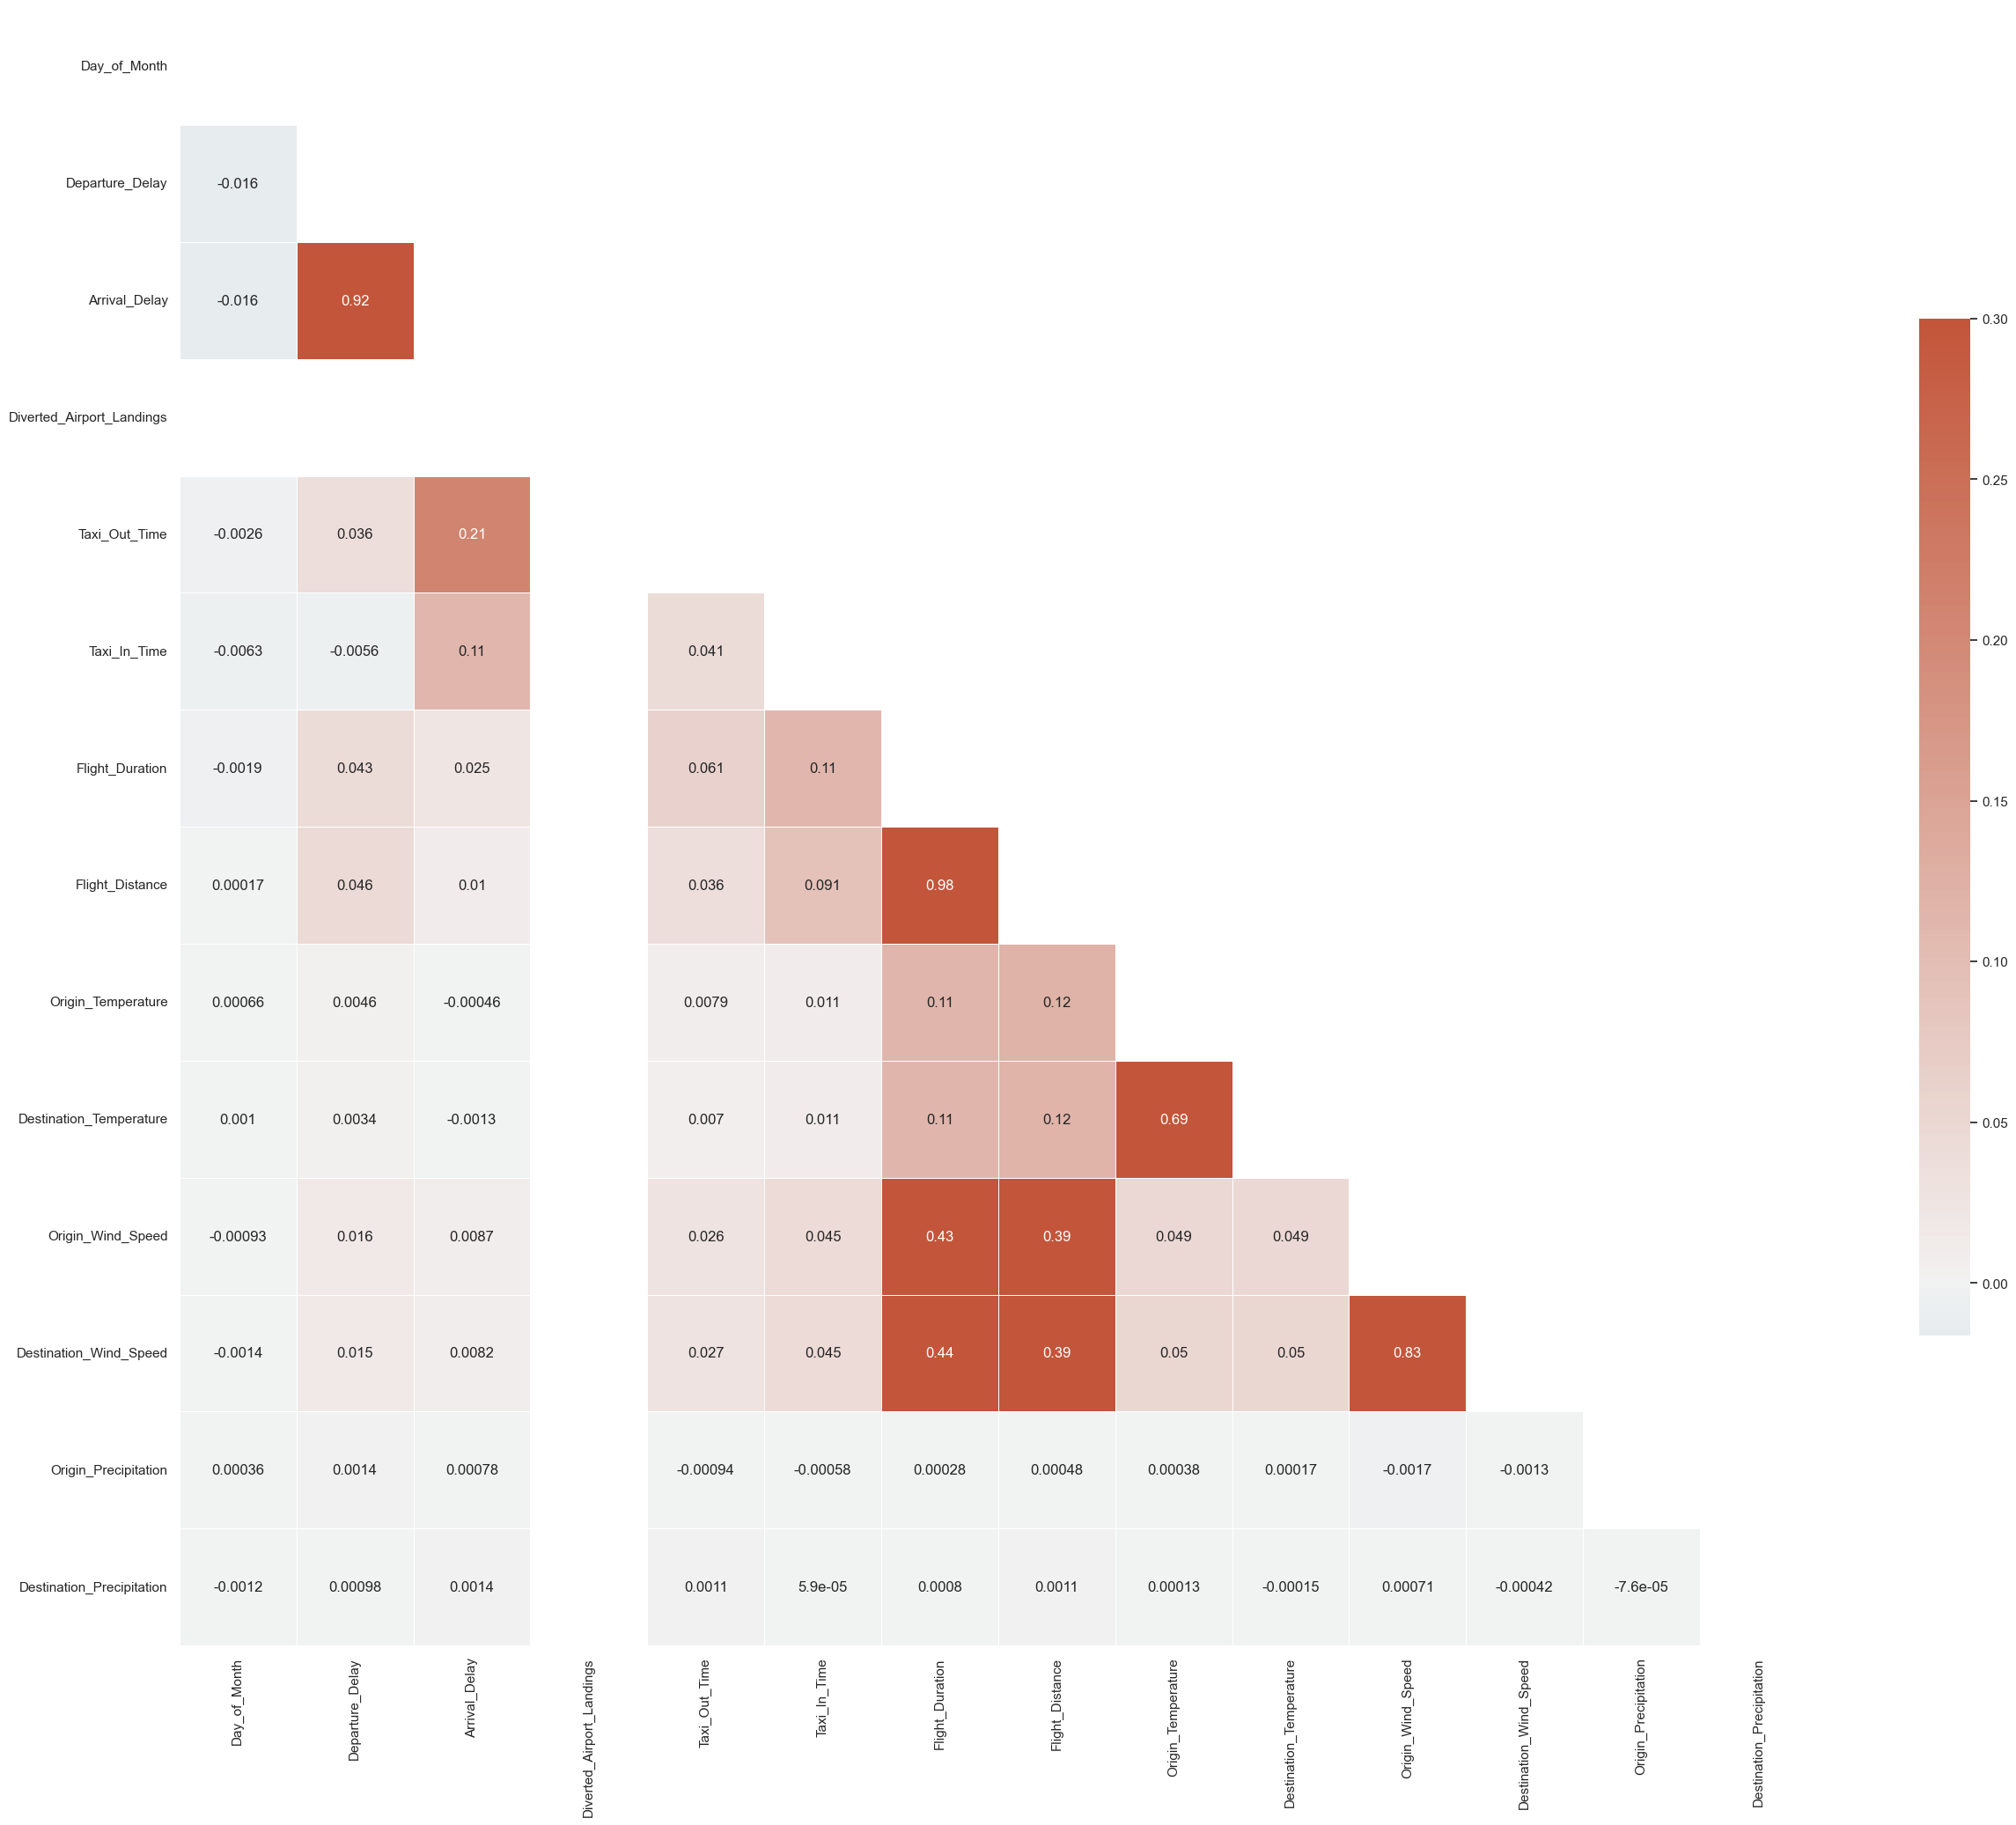

In [75]:
correlation_matrix = delays.select_dtypes(include=['int', 'float']).corr()

sns.set(style='white')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Extremely High correlation (Flight Duration and Distance) -> To prevent information duplication it will be better to reject one of these variables. Longer distance have to have longer duration. Duration is higher correlated with windspeed than distance so it's better to reject duration from the model. Destination and Origin Wind Speed also highly correlated bcs most of the locations are close to each other. But it's not a rule, we have observations on much longer distances. Similar situation with temperature. 0.92 correlation also has Departure_Delay with Arrival_Delay. We can not reject Departure_Delay bcs as we can see it might a feature with the most influence on target variable.

# Violin plots

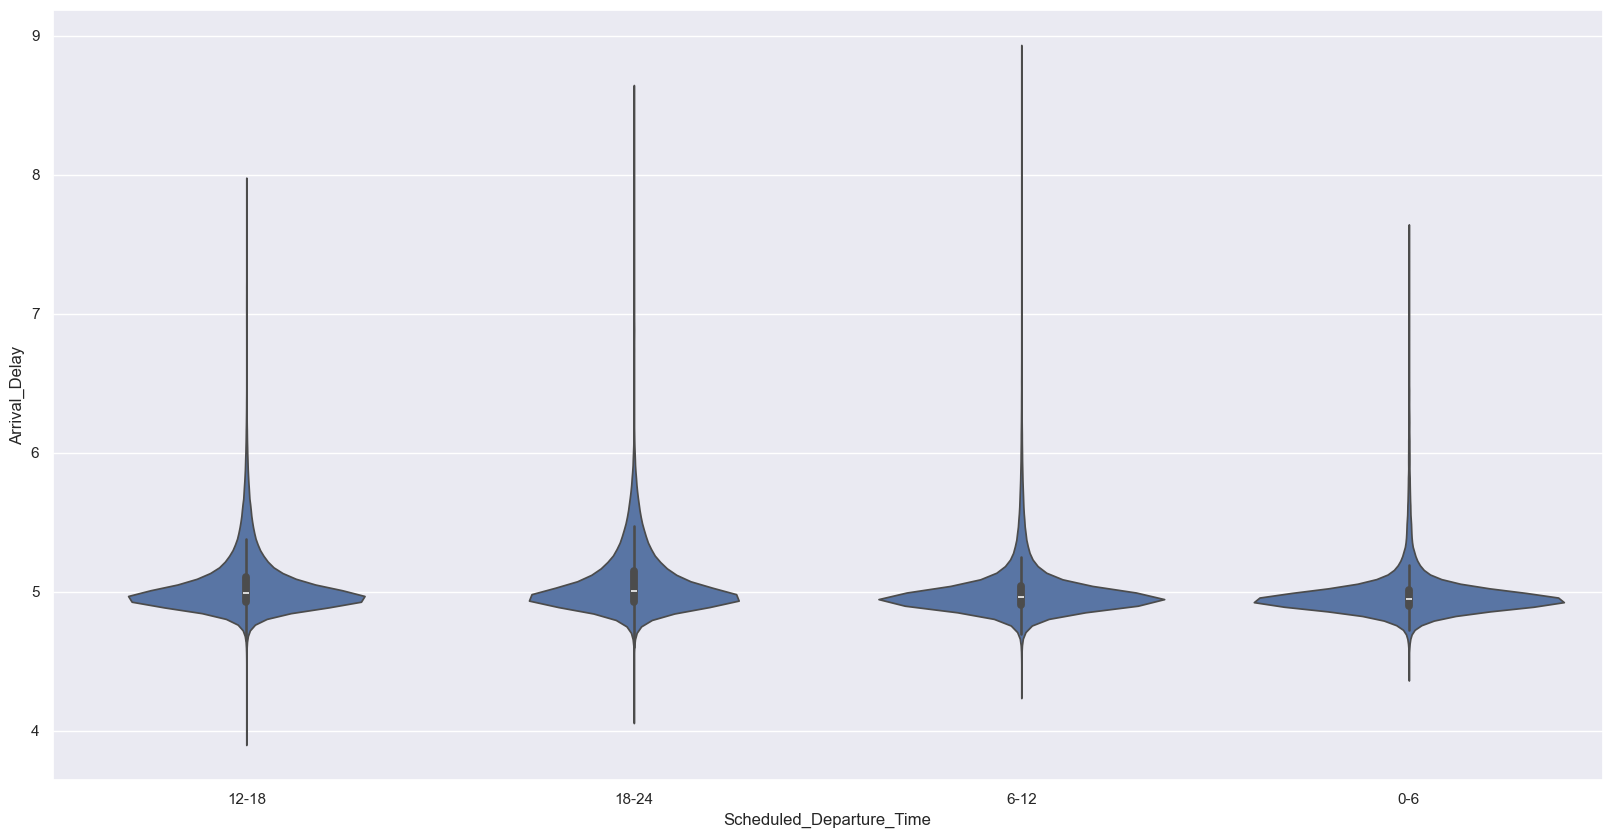

In [76]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = delays.Scheduled_Departure_Time, y = delays.Arrival_Delay)

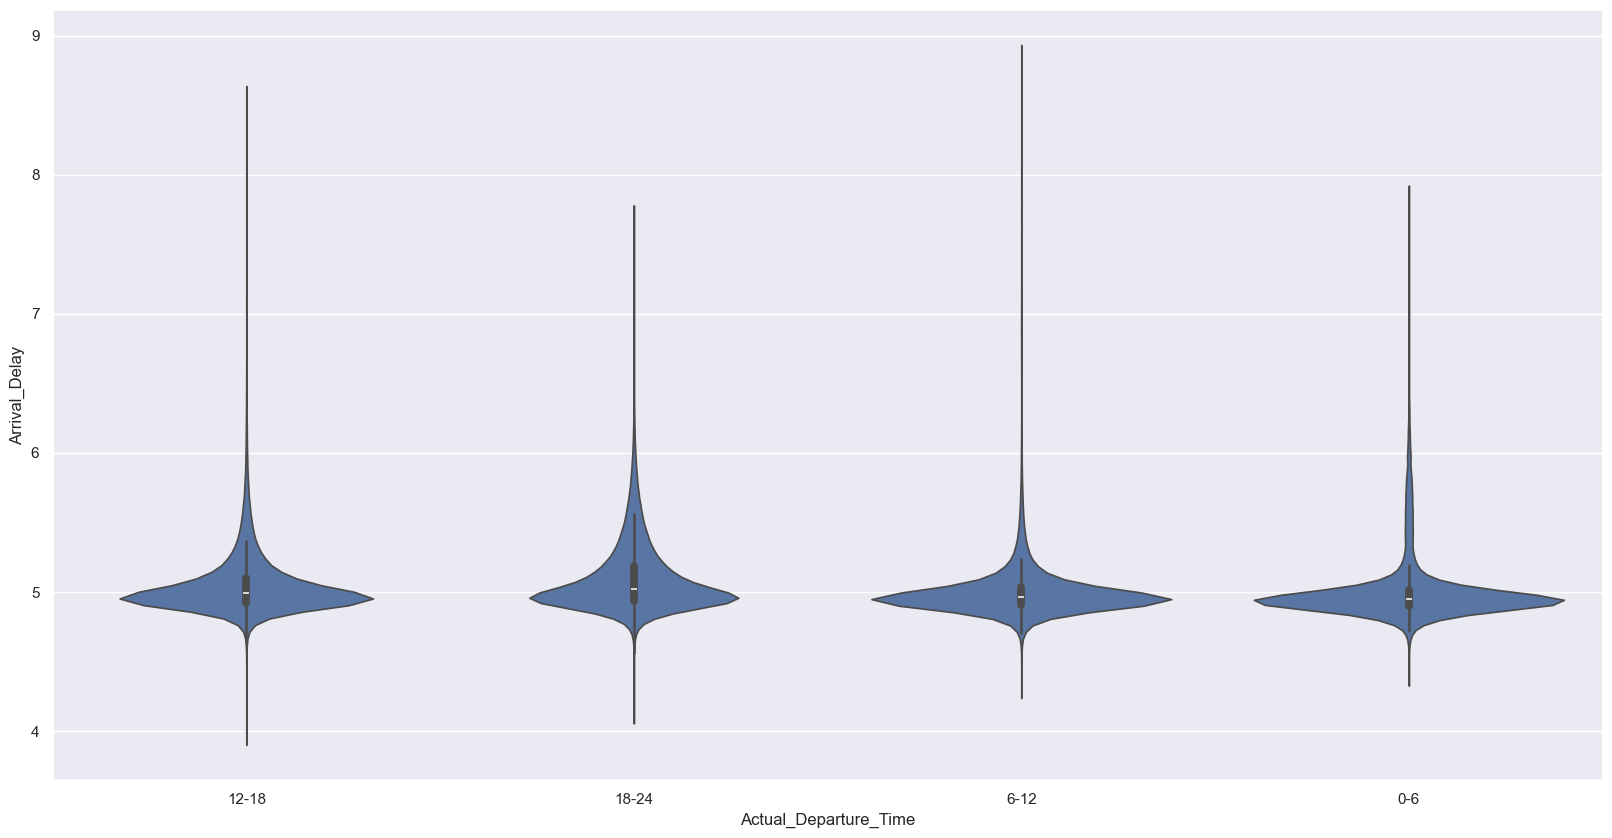

In [77]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = delays.Actual_Departure_Time, y = delays.Arrival_Delay)

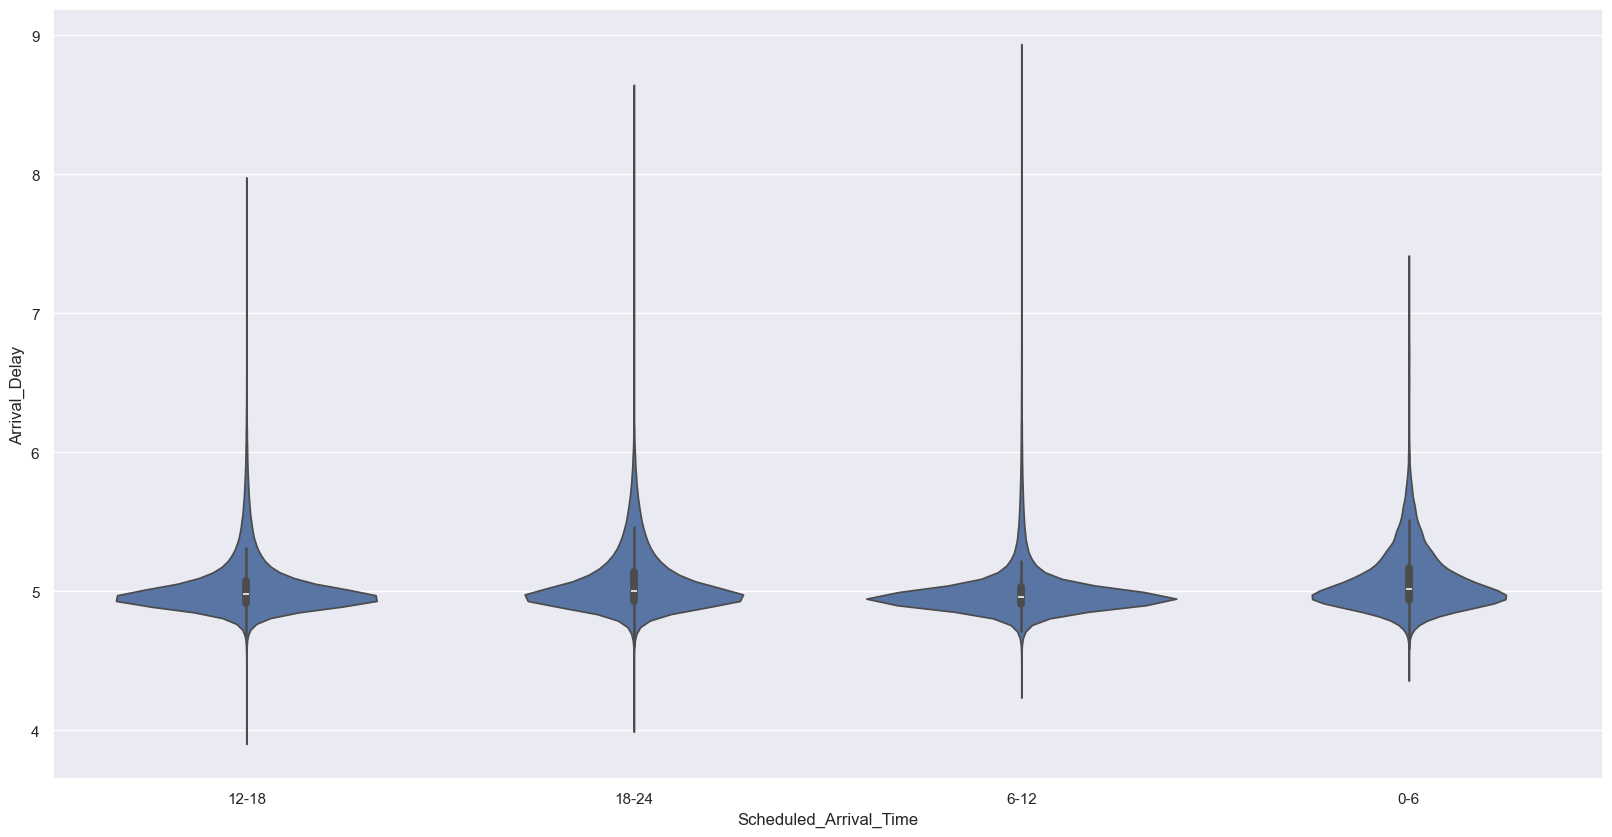

In [78]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.violinplot(x = delays.Scheduled_Arrival_Time, y = delays.Arrival_Delay)

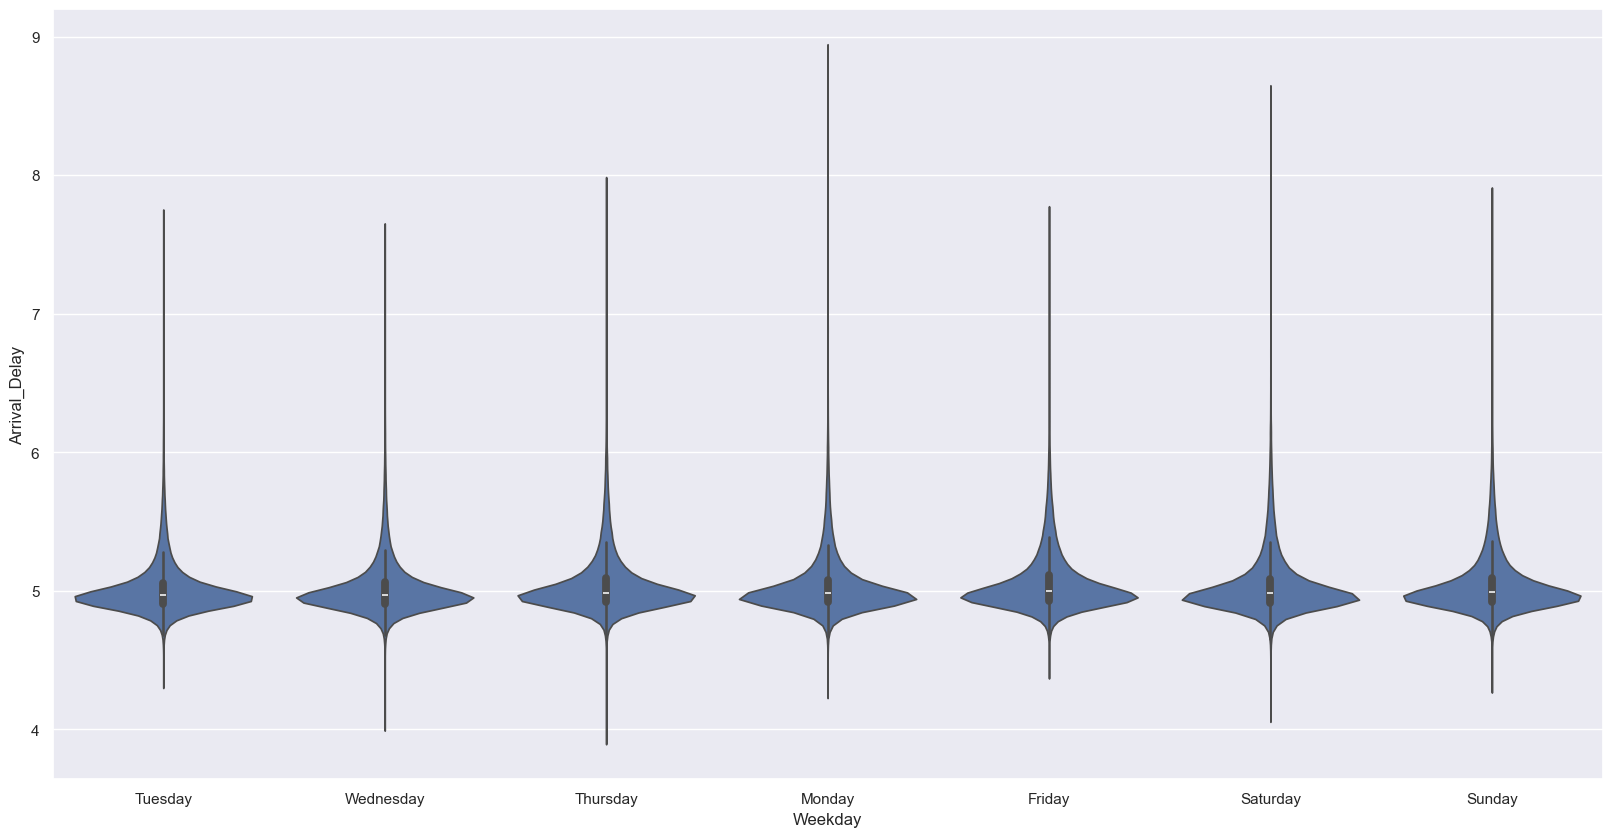

In [79]:
ax = sns.violinplot(x = delays.Weekday, y = delays.Arrival_Delay, scale = "width")

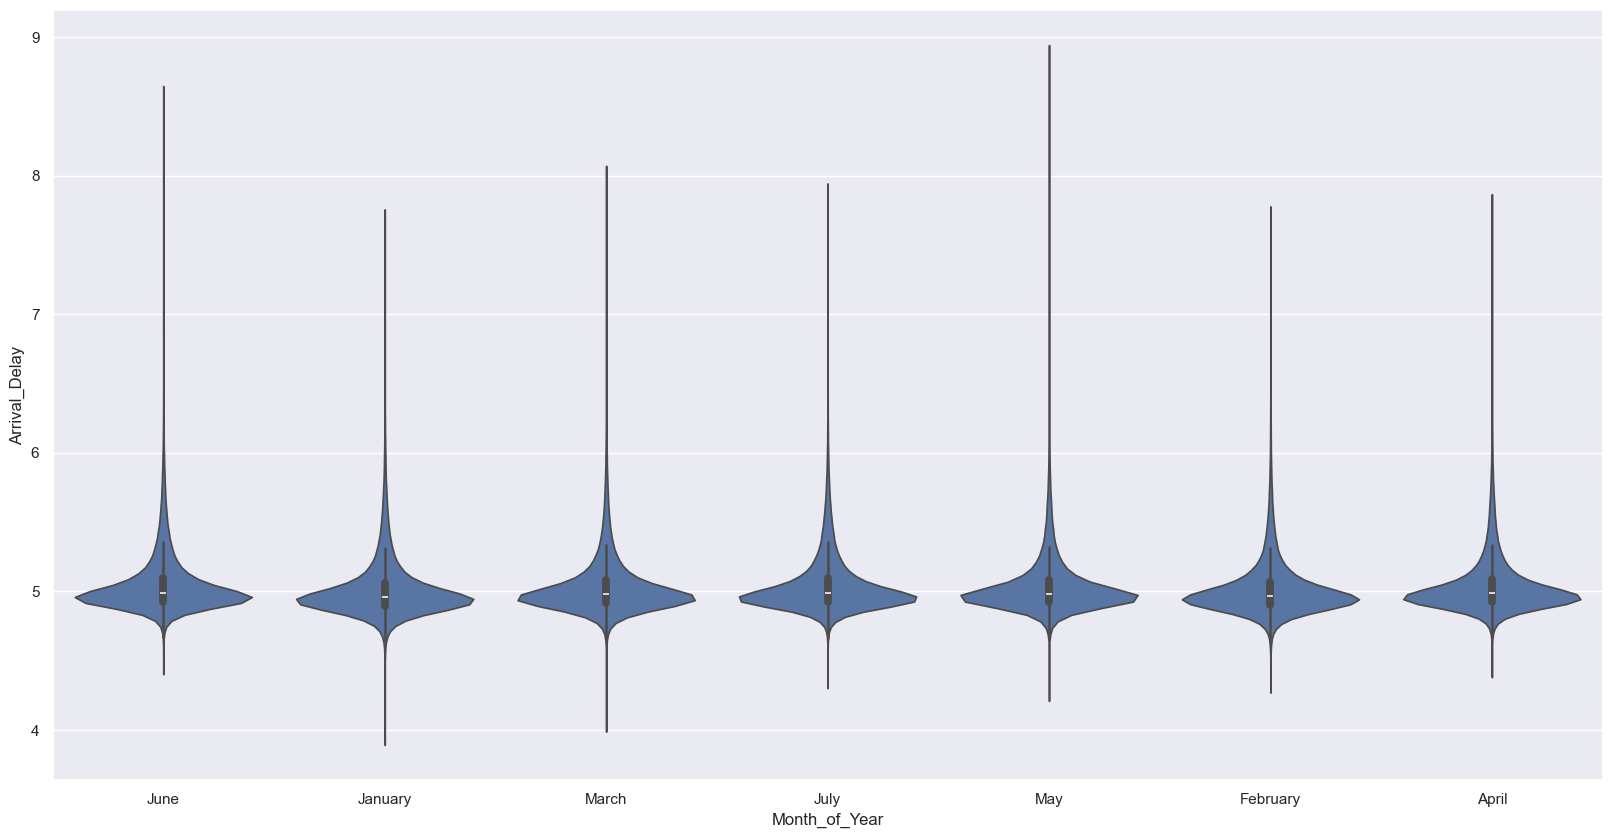

In [80]:
ax = sns.violinplot(x = delays.Month_of_Year, y = delays.Arrival_Delay, scale = "width")

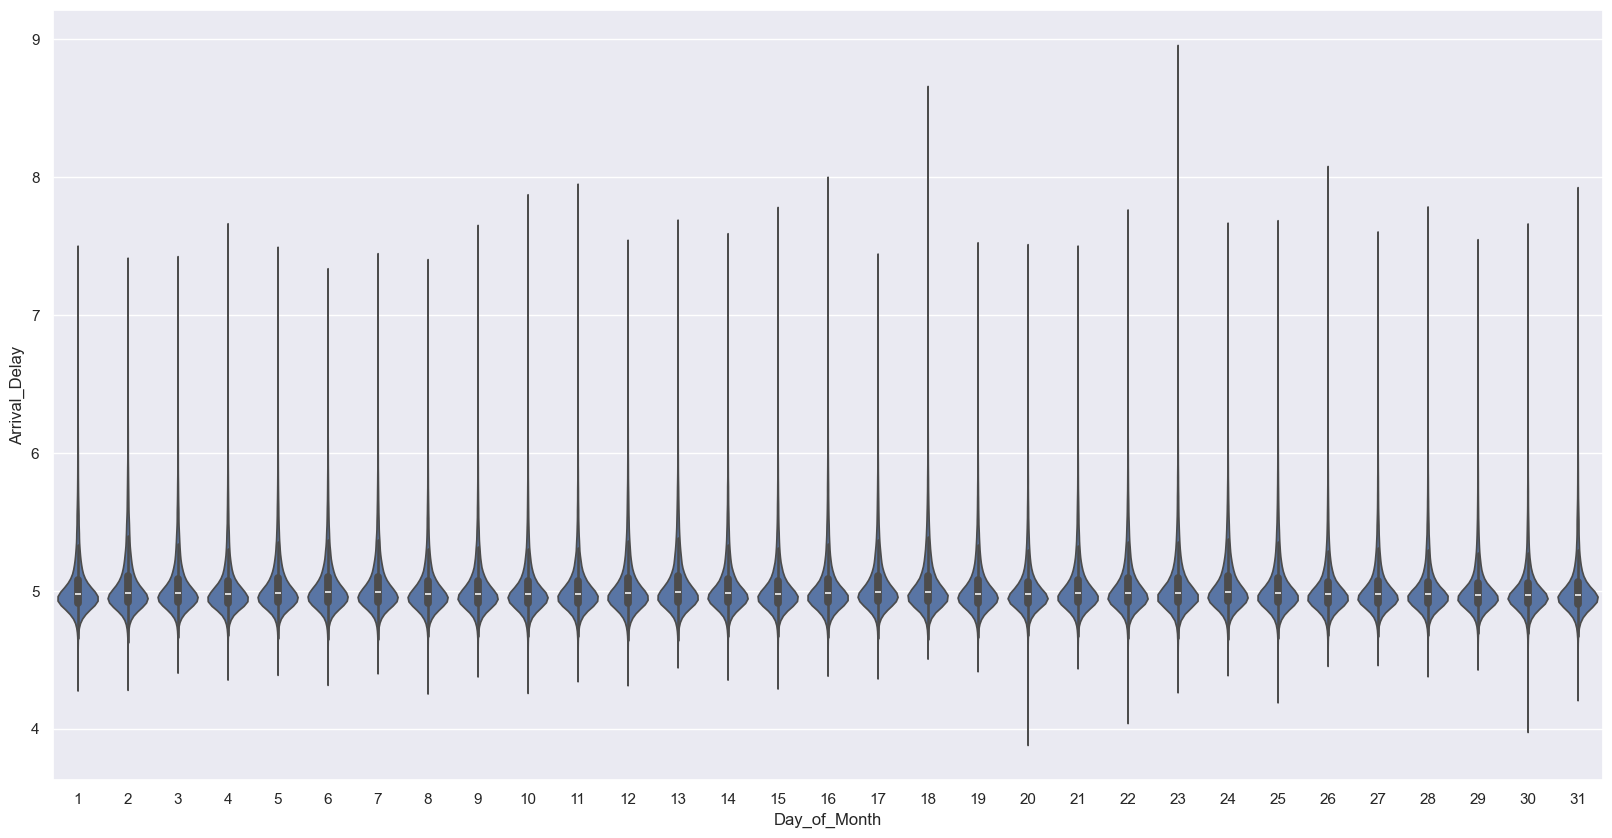

In [81]:
ax = sns.violinplot(x = delays.Day_of_Month, y = delays.Arrival_Delay, scale = "width")


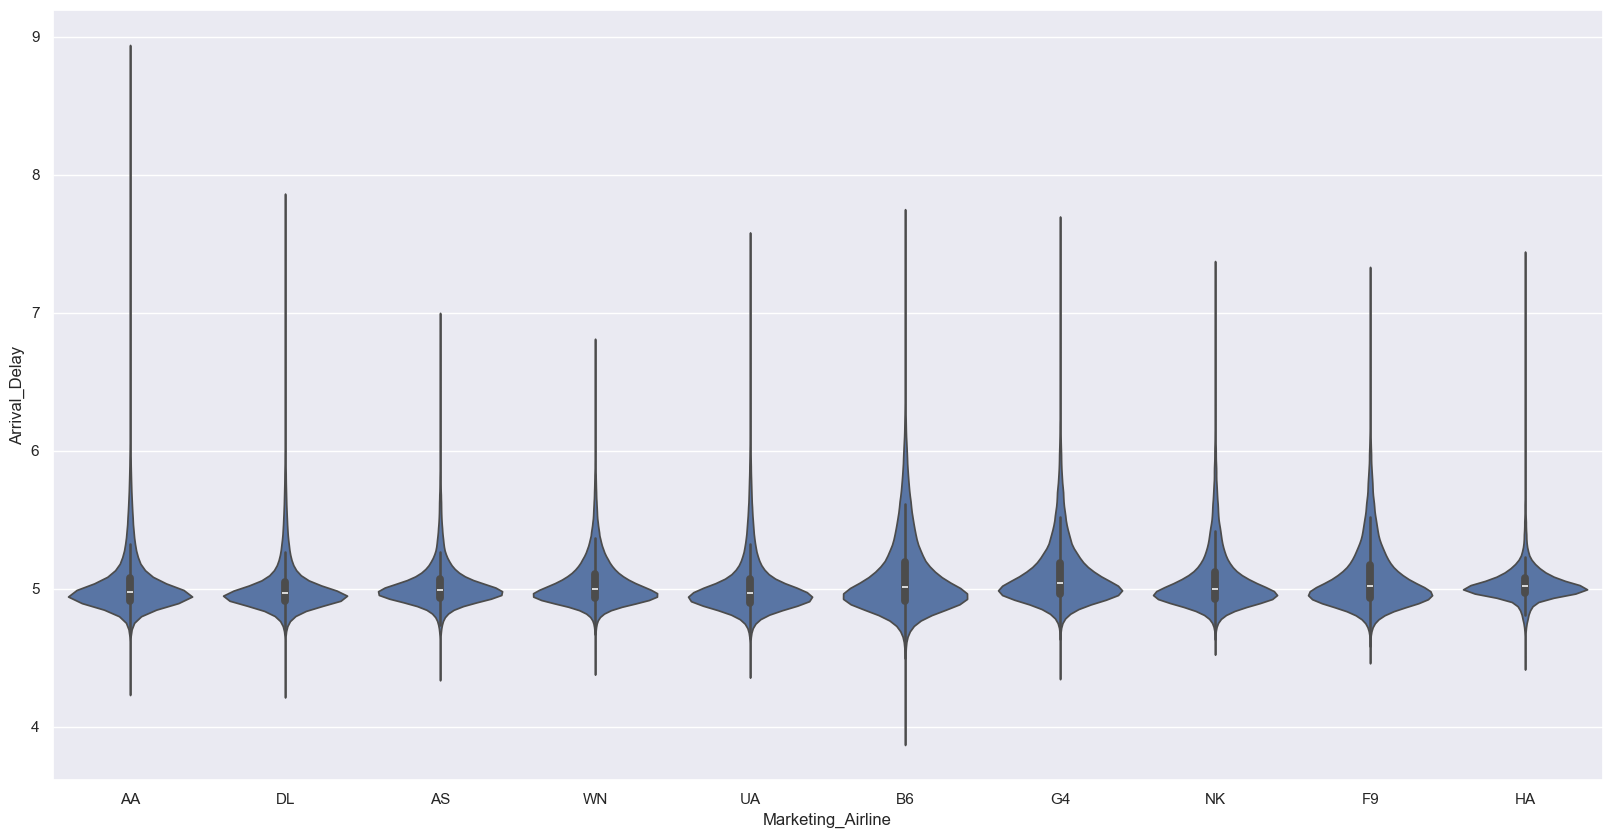

In [82]:
ax = sns.violinplot(x = delays.Marketing_Airline, y = delays.Arrival_Delay, scale = "width")

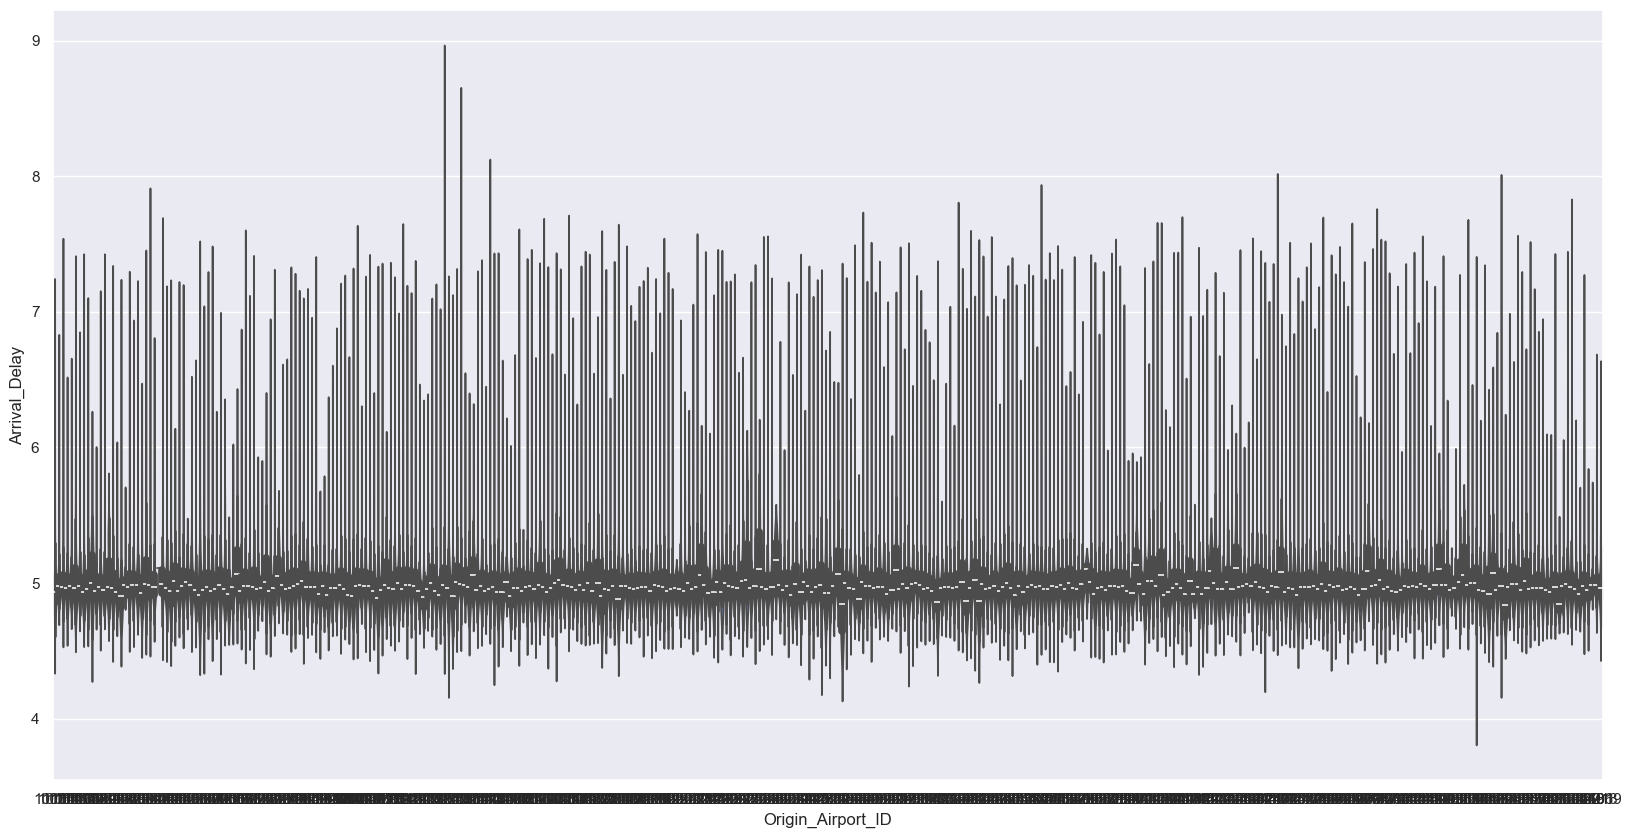

In [83]:
ax = sns.violinplot(x = delays.Origin_Airport_ID, y = delays.Arrival_Delay, scale = "width")

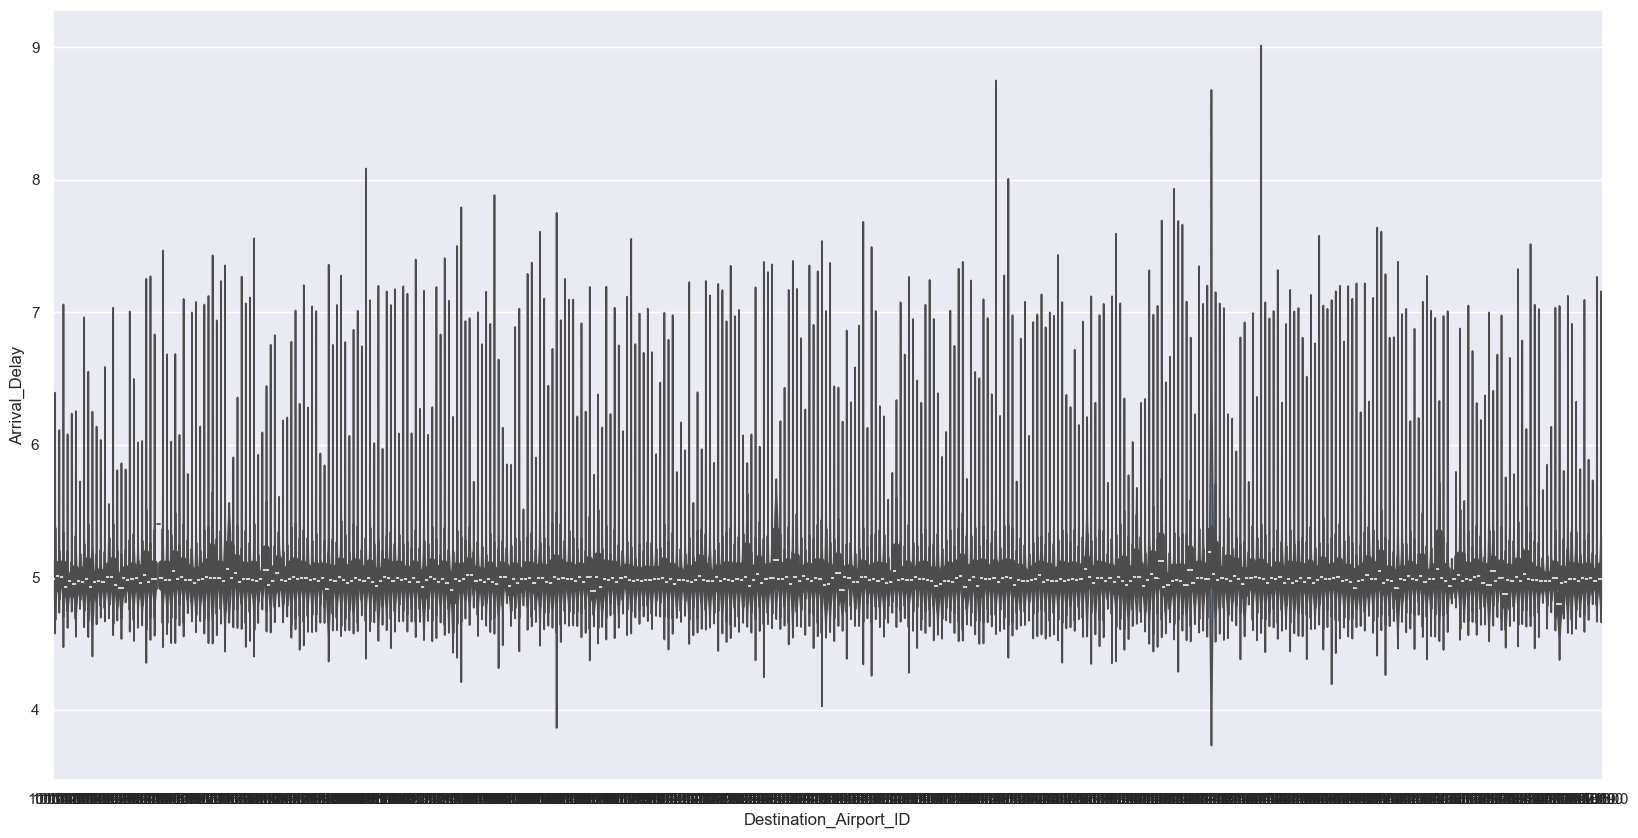

In [84]:
ax = sns.violinplot(x = delays.Destination_Airport_ID, y = delays.Arrival_Delay, scale = "width")

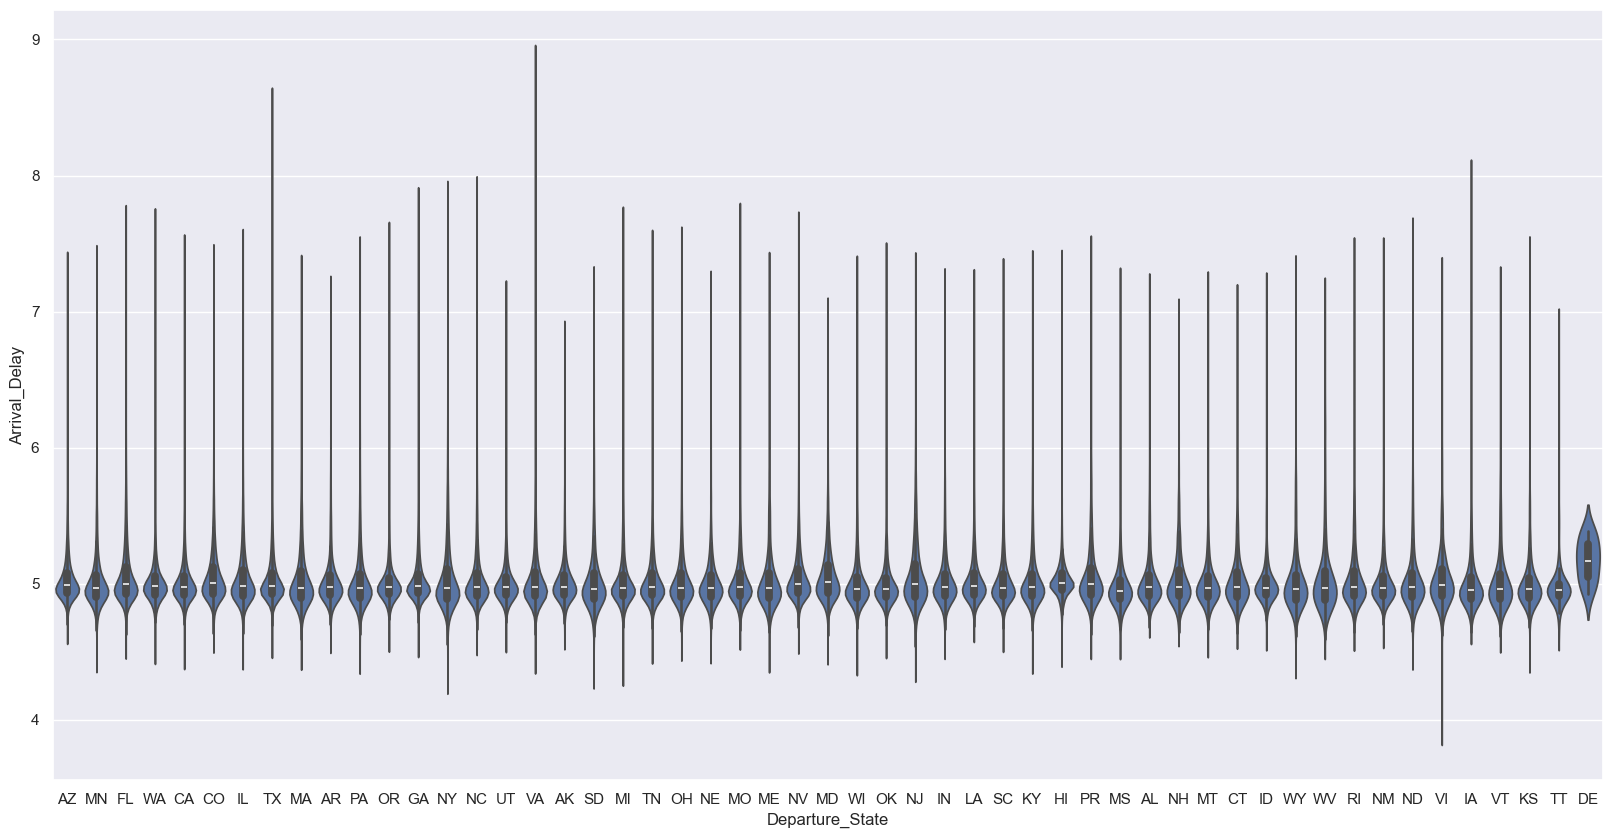

In [85]:
ax = sns.violinplot(x = delays.Departure_State, y = delays.Arrival_Delay, scale = "width")

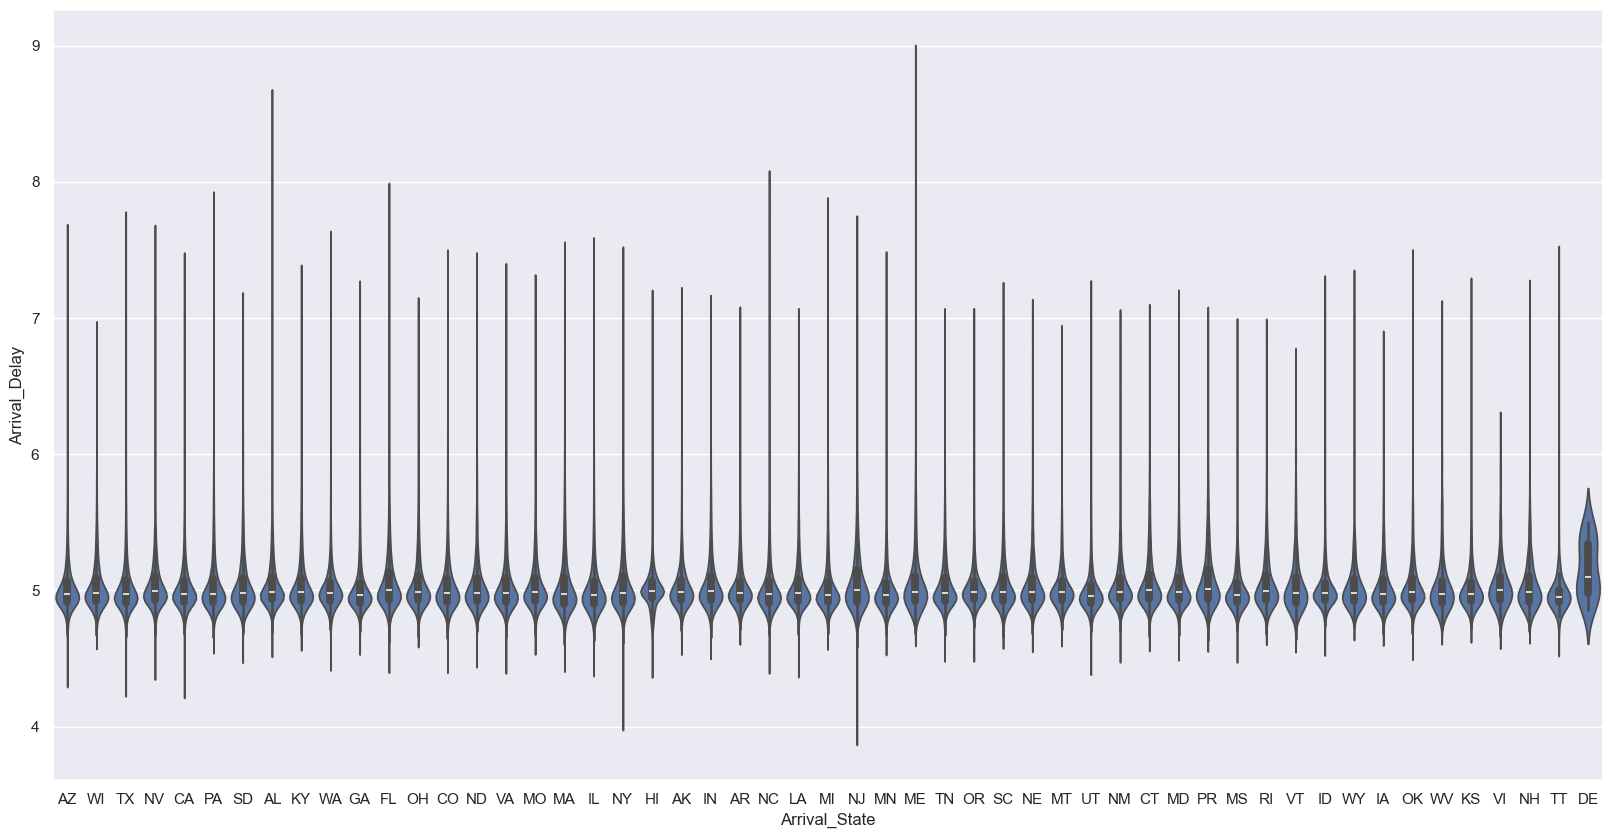

In [86]:
ax = sns.violinplot(x = delays.Arrival_State, y = delays.Arrival_Delay, scale = "width")

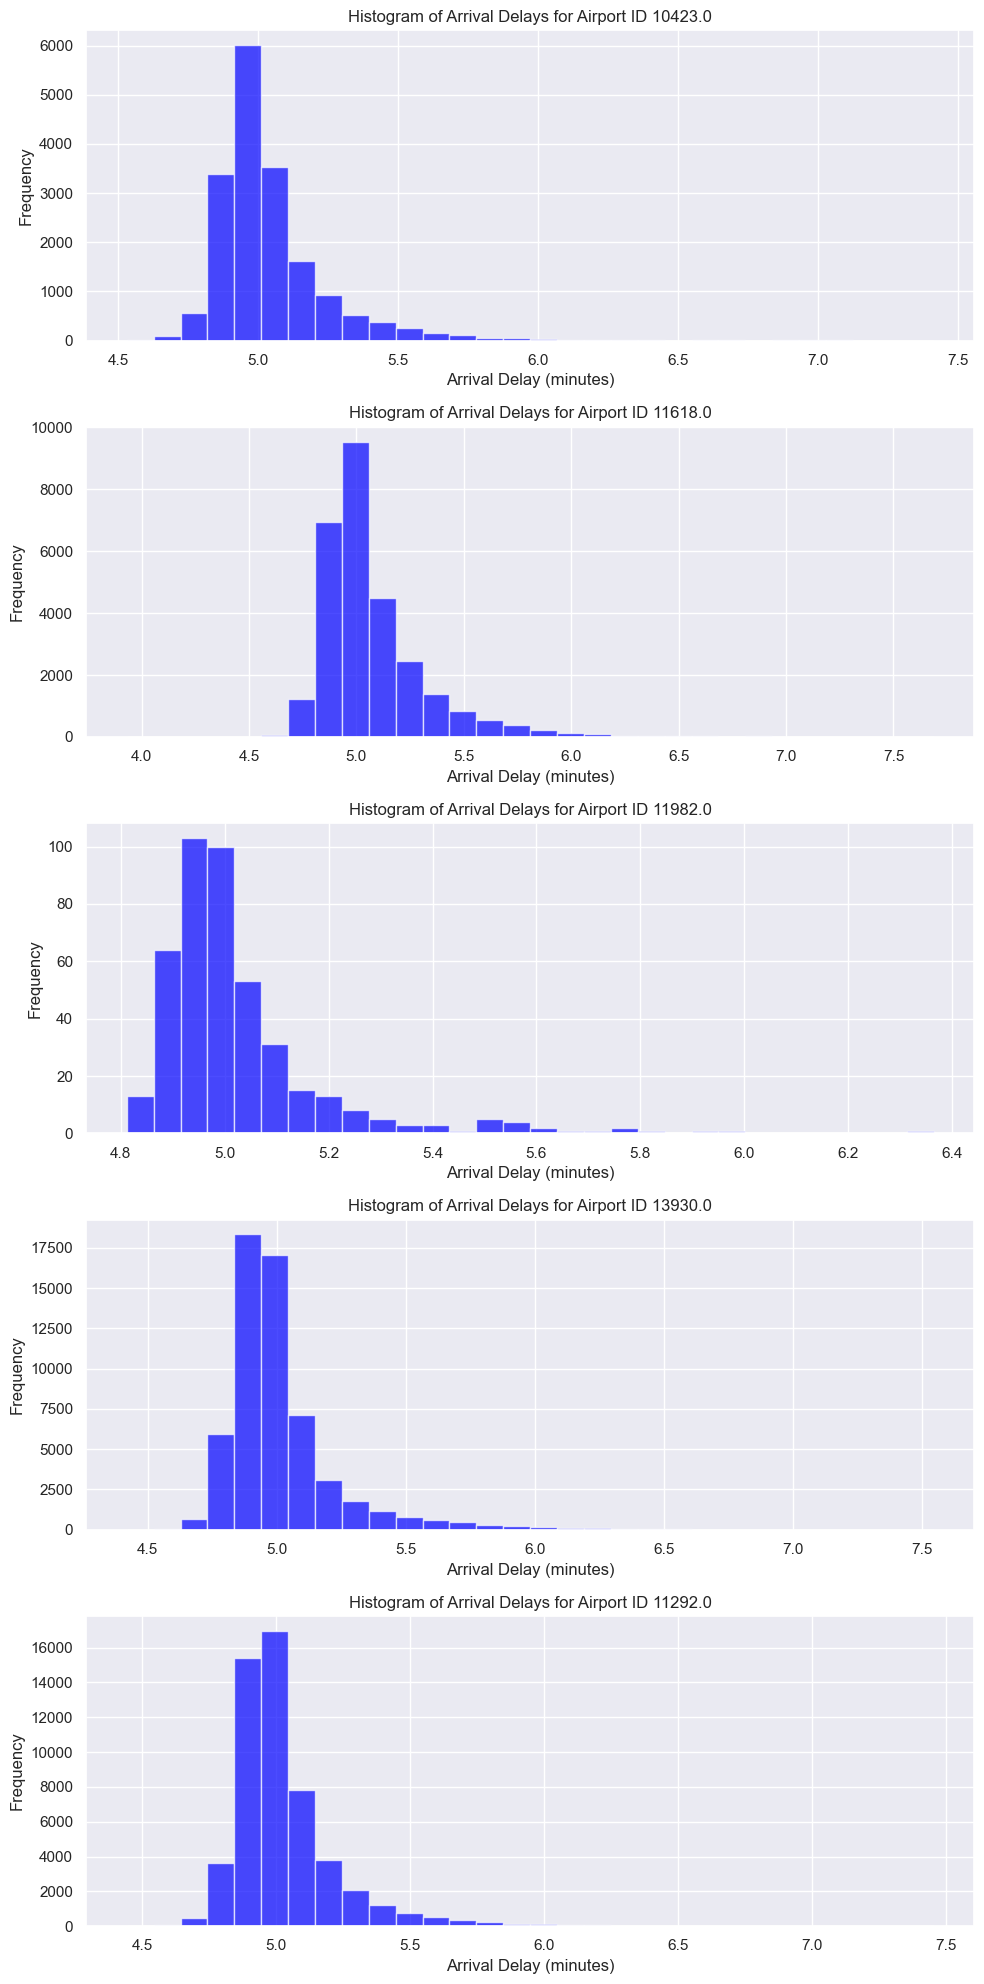

In [87]:
random_airports = delays['Destination_Airport_ID'].dropna().sample(5, random_state=1)

filtered_data = delays[delays['Destination_Airport_ID'].isin(random_airports)]

fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for i, airport_id in enumerate(random_airports):
    data = filtered_data[filtered_data['Destination_Airport_ID'] == airport_id]['Arrival_Delay']
    axs[i].hist(data, bins=30, color='blue', alpha=0.7)
    axs[i].set_title(f'Histogram of Arrival Delays for Airport ID {airport_id}')
    axs[i].set_xlabel('Arrival Delay (minutes)')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [88]:
mode_delays = delays.groupby('Destination_Airport_ID')['Arrival_Delay'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_delays.columns = ['Destination_Airport_ID', 'Mode_Destination_Arrival_Delay']

delays = pd.merge(delays, mode_delays, on='Destination_Airport_ID', how='left')

mode_delays = delays.groupby('Origin_Airport_ID')['Arrival_Delay'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_delays.columns = ['Origin_Airport_ID', 'Mode_Origin_Arrival_Delay']

delays = pd.merge(delays, mode_delays, on='Origin_Airport_ID', how='left')

In [91]:
delays.describe()

,Day_of_Month,Departure_Delay,Arrival_Delay,Diverted_Airport_Landings,Taxi_Out_Time,Taxi_In_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation,Mode_Destination_Arrival_Delay,Mode_Origin_Arrival_Delay
count,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1384837.00,1386207.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1420021.00,1386412.00,1420021.00
mean,15.78,5.08,5.04,0.00,2.80,2.03,4.54,6.42,0.00,0.00,0.00,0.00,0.10,0.11,4.49,4.52
std,8.73,0.19,0.22,0.00,0.40,0.51,0.60,0.76,1.00,1.00,1.00,1.00,0.34,0.34,0.17,0.11
min,1.00,4.29,3.93,0.00,0.69,0.69,2.20,3.47,-3.13,-2.97,-2.41,-2.40,0.00,0.00,3.93,3.93
25%,8.00,4.98,4.92,0.00,2.48,1.61,4.11,5.91,-0.63,-0.63,-0.34,-0.34,0.00,0.00,4.42,4.47
50%,16.00,5.01,4.98,0.00,2.77,1.95,4.55,6.47,-0.19,-0.19,0.15,0.15,0.00,0.00,4.53,4.53
75%,23.00,5.08,5.08,0.00,3.00,2.30,4.96,6.94,0.31,0.31,0.62,0.62,0.00,0.00,4.62,4.60
max,31.00,8.91,8.91,0.00,5.40,5.64,6.52,8.54,2.46,2.46,3.55,3.61,2.00,2.00,5.40,5.11


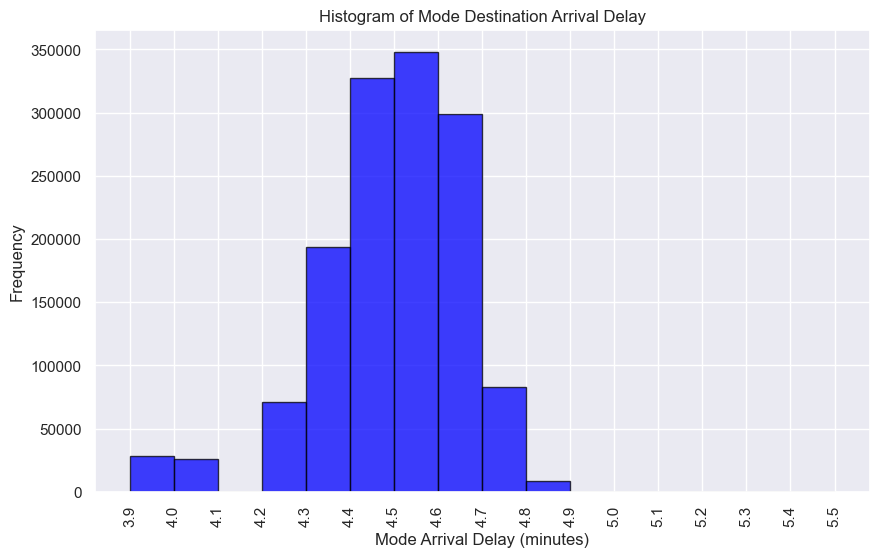

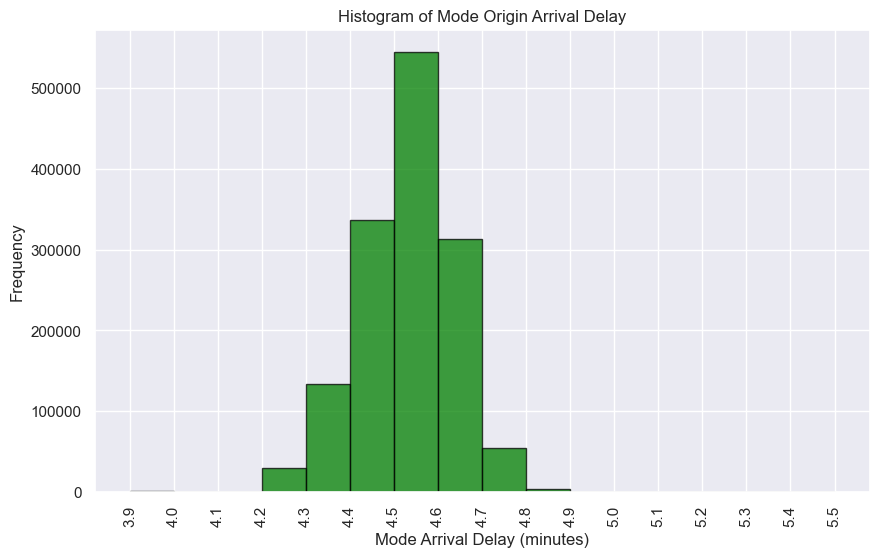

In [103]:
# Ustawienie granic kubełków zaczynając od 3.9 do 5.5 co 0.1
bins = [3.9 + 0.1 * i for i in range(int((5.5 - 3.9) / 0.1) + 1)]

# Histogram dla Mode_Destination_Arrival_Delay
plt.figure(figsize=(10, 6))
plt.hist(delays['Mode_Destination_Arrival_Delay'], bins=bins, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Mode Destination Arrival Delay')
plt.xlabel('Mode Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(bins)  # Dodaje etykiety osi x dla lepszej czytelności
plt.xticks(rotation=90)  # Obrót etykiet, aby były czytelniejsze
plt.show()

# Histogram dla Mode_Origin_Arrival_Delay
plt.figure(figsize=(10, 6))
plt.hist(delays['Mode_Origin_Arrival_Delay'], bins=bins, alpha=0.75, color='green', edgecolor='black')
plt.title('Histogram of Mode Origin Arrival Delay')
plt.xlabel('Mode Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(bins)  # Dodaje etykiety osi x dla lepszej czytelności
plt.xticks(rotation=90)  # Obrót etykiet, aby były czytelniejsze
plt.show()


In [104]:
delays['Rounded_Mode_Destination_Arrival_Delay'] = delays['Mode_Destination_Arrival_Delay'].round(1)
delays['Rounded_Mode_Origin_Arrival_Delay'] = delays['Mode_Origin_Arrival_Delay'].round(1)

# Grupowanie dla lotnisk docelowych
destination_groups = delays.groupby('Rounded_Mode_Destination_Arrival_Delay')['Destination_Airport_ID'].unique()
destination_groups = destination_groups.reset_index()
destination_groups.columns = ['Mode_Arrival_Delay', 'Airports']

# Grupowanie dla lotnisk początkowych
origin_groups = delays.groupby('Rounded_Mode_Origin_Arrival_Delay')['Origin_Airport_ID'].unique()
origin_groups = origin_groups.reset_index()
origin_groups.columns = ['Mode_Arrival_Delay', 'Airports']

print("Destination Airport Groups by Mode Arrival Delay:")
print(destination_groups)

print("\nOrigin Airport Groups by Mode Arrival Delay:")
print(origin_groups)


Destination Airport Groups by Mode Arrival Delay:
    Mode_Arrival_Delay                                           Airports
0                 3.90                                          [11618.0]
1                 4.10                                          [12478.0]
2                 4.20                                          [14679.0]
3                 4.30  [11298.0, 14771.0, 14107.0, 12892.0, 12266.0, ...
4                 4.40  [12889.0, 11292.0, 11697.0, 12264.0, 13930.0, ...
5                 4.50  [15376.0, 14747.0, 10423.0, 10721.0, 12758.0, ...
6                 4.60  [14100.0, 11775.0, 13422.0, 11193.0, 10397.0, ...
7                 4.70  [13076.0, 14082.0, 11066.0, 13433.0, 11042.0, ...
8                 4.80  [12335.0, 14633.0, 15070.0, 12003.0, 12397.0, ...
9                 4.90  [11470.0, 11905.0, 11525.0, 15389.0, 14709.0, ...
10                5.00                                          [14222.0]
11                5.40                                        